<a href="https://colab.research.google.com/github/zhus-dika/railways_caclulations/blob/main/regression_arma_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐫 Realize regression model

## 🦀 Download data

### 🪰 Install need packages

In [2]:
# ! apt install x13as
! pip install pyexcel pyexcel-xls pyexcel-xlsx

### 🐳 Imports

In [3]:
import pandas as pd
import statsmodels.api as sm
import gdown
from datetime import datetime
import math
import numpy as np

import seaborn as sns

from openpyxl import load_workbook
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import itertools
import statsmodels.api as sm

### 🦥 Constants

In [4]:
selected_types = ['Coal', 'Petrol', 'Scrap', 'Chem', 'Fert', 'nFerr', 'Iron']

### 🐻‍❄️ Useful methods

In [5]:
def construct_serial_data_by_type(type, df, dct_serial):
  dates = [datetime.strptime(i, '%y-%m') for i in df.columns]
  serial_dates = {i: [] for i in dct_serial[type]}
  for idx, date in enumerate(dates):
    for key, value in serial_dates.items():
      dt = datetime.strptime(key[3:5]+'-'+key[-2:], '%y-%m')
      if date == dt:
        serial_dates[key].append(1)
      else:
        serial_dates[key].append(0)
  return serial_dates

In [6]:
start = 2002
end = 2024

def excel_columns(n):
    columns = []
    for i in range(1, n + 1):
        col = ""
        num = i
        while num > 0:
            num -= 1
            col = chr(65 + (num % 26)) + col
            num //= 26
        columns.append(col)
    return columns

column_names = excel_columns(14 * (end - start + 1))

In [7]:
def fill_transportation_tariffs(table_data, start, end):
  commodities_transportation_tariffs = {datetime.strptime(str(year) + '-' + str(i), '%Y-%m').strftime("%y-%m"): [] for year in range(start, end + 1) for i in range(1, 13)}
  commodities_transportation_tariffs['name'] = []
  name_column = 'A'
  for i in range(1, 82):
    if i % 4 == 0:
      value = table_data[name_column+str(i)].value
      value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').replace("\n", " ").lower()
      name = " ".join(value.split())
      commodities_transportation_tariffs['name'].append(name)

      for column_num in range((end - start + 1) * 12):
        val_volume = table_data[column_names[column_num + 2 + math.floor(column_num / 12)] + str(i + 1)].value
        commodities_transportation_tariffs[datetime.strptime(str(start + math.floor(column_num / 12))  + '-' + str(column_num % 12 + 1), '%Y-%m').strftime("%y-%m")].append(val_volume)
  return commodities_transportation_tariffs

In [8]:
def plot_regression_results(model, df):
  df["fitted"] = model.fittedvalues
  df["residuals"] = model.resid

  # Plot of actual, predicted, and residual values
  fig, ax1 = plt.subplots(figsize=(20, 10))

  # Actual and predicted lines
  ax1.plot(df.index, df["V_SA"], color="red", label="Actual")
  ax1.plot(df.index, df["fitted"], color="green", label="Fitted")

  # Second axis for residuals
  ax2 = ax1.twinx()
  ax2.plot(df.index, df["residuals"], color="blue", label="Residual", alpha=0.7)

  # Add a horizontal line at level 0 for residuals
  ax2.axhline(0, linestyle="--", color="black", linewidth=0.8)

  ax1.legend(loc="upper right")
  ax2.legend(loc="lower right")

  # Axis titles
  ax1.set_xlabel("Date")
  ax1.set_ylabel("Actual & Fitted")
  ax2.set_ylabel("Residuals")


  step = max(10, len(df.columns))  # Количество подписей по X не больше 10

  ax1.set_xticks(df.index[::step])
  ax1.set_xticklabels(df.index[::step], rotation=45, fontsize=11)  # Красиво форматируем

  ax2.set_xticks(df.index[::step])
  ax2.set_xticklabels(df.index[::step], rotation=45, fontsize=11)  # Красиво форматируем
  #ax1.set_xticklabels(ax1.get_xticks(), rotation = 45, fontsize=6)
  plt.title("Actual, Fitted, and Residuals Plot")
  plt.show()

## 🐟 Read data

### 🐺 Getting indexed adjustment volumes data

In [9]:
url = "https://drive.google.com/uc?id=1XkKQQFYVFEgeOibNQmOtsdE0dCXSAri_"
volumes = 'volumes.xlsx'
gdown.download(url, volumes, quiet=False);


df_volumes = pd.read_excel('volumes.xlsx', index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1XkKQQFYVFEgeOibNQmOtsdE0dCXSAri_
To: /content/volumes.xlsx
100%|██████████| 115k/115k [00:00<00:00, 10.9MB/s]


In [10]:
df_volumes = df_volumes.rename(columns={date: date.strftime('%y-%m') for date in df_volumes.columns})

In [11]:
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06  \
type                                                                          
Cement_adjusted  1.147336  1.102376  0.892257  0.905910  1.308594  1.430011   
Oil_adjusted     1.114516  1.124344  1.086534  1.077561  1.160076  1.115107   
Lim              1.237137  1.166720  1.155531  1.217076  1.027536  1.131633   
Drinks           1.043722  1.053523  1.011548  1.174385  1.048721  1.125662   
nFerr_adjusted   0.988432  1.000357  0.983268  0.977983  1.005570  0.946232   

                    03-07     03-08     03-09     03-10  ...     24-03  \
type                                                     ...             
Cement_adjusted  1.325809  1.229607  1.270885  1.222293  ...  0.818200   
Oil_adjusted     1.015461  0.994196  1.027111  1.063774  ...  0.996553   
Lim              0.929957  0.925049  1.195331  1.386189  ...  1.167459   
Drinks           1.104773  1.171640  1.295955  1.136263  ...  1.009987   
nFerr_adjusted   0.984209  0.950758  0.979675  1.010900  ...  0.884406   

                    24-04     24-05     24-06     24-07     24-08     24-09  \
type                                                                          
Cement_adjusted  1.018180  0.966344  0.968121  1.033922  1.064140  1.089983   
Oil_adjusted     0.978653  0.955117  0.973056  1.025939  0.997069  1.022066   
Lim              1.127516  1.046738  0.996614  1.002212  0.926467  0.792161   
Drinks           1.017857  1.032304  0.981057  1.045963  1.009073  1.028256   
nFerr_adjusted   0.989413  1.034805  0.985319  0.993452  1.000949  0.989031   

                    24-10     24-11     24-12  
type                                           
Cement_adjusted  0.983672  0.948599  1.083497  
Oil_adjusted     0.814616  0.927846  0.905966  
Lim              1.005755  1.111818  1.007404  
Drinks           1.090515  1.037864  1.135231  
nFerr_adjusted   0.995625  0.950038  0.989594  

[5 rows x 264 columns]

🦐 Filter only adjusted rows

In [12]:
adjusted_rows = [i for i in df_volumes.index if len(i.split('_')) > 1]

mask = df_volumes.index.isin(adjusted_rows)
df_volumes = df_volumes[mask]

In [13]:
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06  \
type                                                                          
Black_adjusted   1.107154  1.032615  1.036182  1.121432  0.964139  1.101222   
Iron_adjusted    1.196323  1.137040  1.090749  1.076335  1.193487  1.106854   
ColOre_adjusted  1.170649  1.088629  1.004364  1.007313  1.017305  1.066902   
Cement_adjusted  1.147336  1.102376  0.892257  0.905910  1.308594  1.430011   
Wheat_adjusted   1.405050  1.335464  1.243198  1.222072  1.201595  1.164400   

                    03-07     03-08     03-09     03-10  ...     24-03  \
type                                                     ...             
Black_adjusted   1.080336  1.071287  1.114400  1.020916  ...  1.094561   
Iron_adjusted    1.280330  1.251372  1.314330  1.248365  ...  1.350003   
ColOre_adjusted  0.999734  1.022211  0.980279  0.944664  ...  1.143482   
Cement_adjusted  1.325809  1.229607  1.270885  1.222293  ...  0.818200   
Wheat_adjusted   1.046377  0.921651  0.984873  0.996572  ...  0.984923   

                    24-04     24-05     24-06     24-07     24-08     24-09  \
type                                                                          
Black_adjusted   1.033828  1.148415  1.132755  1.118854  1.101313  1.001237   
Iron_adjusted    1.142641  1.207504  1.233599  1.122828  1.392767  1.229503   
ColOre_adjusted  1.076594  1.104551  0.928161  1.156911  1.121502  1.102615   
Cement_adjusted  1.018180  0.966344  0.968121  1.033922  1.064140  1.089983   
Wheat_adjusted   0.906323  1.012457  1.108902  0.909788  1.013309  1.064729   

                    24-10     24-11     24-12  
type                                           
Black_adjusted   1.074308  1.052041  1.079446  
Iron_adjusted    1.179020  1.171365  0.987085  
ColOre_adjusted  1.081331  1.025729  1.044812  
Cement_adjusted  0.983672  0.948599  1.083497  
Wheat_adjusted   1.063984  0.962319  1.089922  

[5 rows x 264 columns]

In [14]:
df_volumes.index = [i.split('_')[0] for i in df_volumes.index]

In [15]:
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
Black   1.107154  1.032615  1.036182  1.121432  0.964139  1.101222  1.080336   
nFerr   0.988432  1.000357  0.983268  0.977983  1.005570  0.946232  0.984209   
ColOre  1.170649  1.088629  1.004364  1.007313  1.017305  1.066902  0.999734   
Oil     1.114516  1.124344  1.086534  1.077561  1.160076  1.115107  1.015461   
Scrap   0.936710  1.089962  0.995131  0.954440  1.143378  1.087669  1.101920   

           03-08     03-09     03-10  ...     24-03     24-04     24-05  \
Black   1.071287  1.114400  1.020916  ...  1.094561  1.033828  1.148415   
nFerr   0.950758  0.979675  1.010900  ...  0.884406  0.989413  1.034805   
ColOre  1.022211  0.980279  0.944664  ...  1.143482  1.076594  1.104551   
Oil     0.994196  1.027111  1.063774  ...  0.996553  0.978653  0.955117   
Scrap   1.097321  1.110280  0.879515  ...  1.120680  1.124807  1.641127   

           24-06     24-07     24-08     24-09     24-10     24-11     24-12  
Black   1.132755  1.118854  1.101313  1.001237  1.074308  1.052041  1.079446  
nFerr   0.985319  0.993452  1.000949  0.989031  0.995625  0.950038  0.989594  
ColOre  0.928161  1.156911  1.121502  1.102615  1.081331  1.025729  1.044812  
Oil     0.973056  1.025939  0.997069  1.022066  0.814616  0.927846  0.905966  
Scrap   2.651149  1.201098  0.866250  1.035905  0.902910  1.205425  1.141718  

[5 rows x 264 columns]

🐹 Plot volumes

In [16]:
# fig, axes = plt.subplots(len(df_volumes), 1, figsize=(38, 4.8 * len(df_volumes)), sharex=False)

# for ax, cargo in zip(axes, df_volumes.index):
#     ax.plot(df_volumes.columns, df_volumes.loc[cargo], marker="o", label=cargo)
#     ax.set_title(cargo)
#     ax.grid()
#     ax.legend()

#     step = 1#max(1, len(df_transportation_volumes.columns))  # Количество подписей по X не больше 10
#     ax.set_xticks(df_volumes.columns[::step])
#     ax.set_xticklabels(df_volumes.columns[::step], rotation=45, fontsize=5)  # Красиво форматируем

# plt.xlabel("Дата")
# plt.show()

### 🐤 Getting indexed adjustment transportation volumes data

In [17]:
url = "https://drive.google.com/uc?id=16ZtXCUT9mo_-nRIrV_V0vm8s-5nZJnXI"
transportation_volumes = 'transportation_volumes.xlsx'
gdown.download(url, transportation_volumes, quiet=False);


df_transportation_volumes = pd.read_excel(transportation_volumes, index_col='type')

Downloading...
From: https://drive.google.com/uc?id=16ZtXCUT9mo_-nRIrV_V0vm8s-5nZJnXI
To: /content/transportation_volumes.xlsx
100%|██████████| 47.2k/47.2k [00:00<00:00, 57.0MB/s]


In [18]:
df_transportation_volumes = df_transportation_volumes.rename(columns={date: date.strftime('%y-%m') for date in df_transportation_volumes.columns})

In [19]:
df_transportation_volumes.head()

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
type                                                                           
Coal    1.146989  1.271296  2.001057  1.617007  1.497430  2.758001  1.602998   
Iron    1.412507  1.134848  1.154288  1.236893  1.152850  1.289855  1.010562   
Oil     1.001428  0.888155  0.881444  1.181056  1.216150  0.812597  0.862972   
Petrol  1.284108  1.637060  1.612777  1.293651  1.817554  1.618301  1.407716   
Corn    1.515605  2.035996  1.108402  1.275258  1.202789  1.805746  1.361368   

           03-08     03-09     03-10  ...      24-03      24-04      24-05  \
type                                  ...                                    
Coal    0.851024  0.779384  0.822710  ...   0.878720   1.096500   1.038759   
Iron    1.016424  1.126092  1.041267  ...   0.743911   0.960014   0.946524   
Oil     0.754016  0.798269  0.892205  ...  15.636156  12.682794  12.677791   
Petrol  1.418118  1.159494  1.268705  ...   1.089231   1.097304   1.135993   
Corn    1.273551  1.334099  1.370246  ...   0.224610   0.264635   0.214934   

            24-06      24-07      24-08     24-09     24-10      24-11  \
type                                                                     
Coal     0.883244   0.927998   0.906847  1.023522  0.953651   0.927396   
Iron     0.947818   0.940809   0.750778  0.922176  0.787614   1.041312   
Oil     10.537268  23.466271  14.472157  8.978876  9.888079  12.936303   
Petrol   0.915309   0.828344   1.044175  1.052666  0.764055   0.842165   
Corn     0.240142   0.152494   0.164547  0.098457  0.064585   0.035981   

            24-12  
type               
Coal     1.114861  
Iron     1.086095  
Oil     14.952227  
Petrol   0.945983  
Corn     0.022325  

[5 rows x 264 columns]

In [20]:
df_volumes = df_volumes[df_transportation_volumes.columns]
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
Wheat   1.405050  1.335464  1.243198  1.222072  1.201595  1.164400  1.046377   
Petrol  1.174994  1.408839  1.107679  1.372890  1.628618  1.181692  1.053518   
Black   1.107154  1.032615  1.036182  1.121432  0.964139  1.101222  1.080336   
Scrap   0.936710  1.089962  0.995131  0.954440  1.143378  1.087669  1.101920   
Lim     1.243567  1.161781  1.088058  1.209383  1.083081  1.137478  0.964124   

           03-08     03-09     03-10  ...     24-03     24-04     24-05  \
Wheat   0.921651  0.984873  0.996572  ...  0.984923  0.906323  1.012457   
Petrol  1.236957  1.099171  0.943648  ...  1.056319  0.776202  0.985852   
Black   1.071287  1.114400  1.020916  ...  1.094561  1.033828  1.148415   
Scrap   1.097321  1.110280  0.879515  ...  1.120680  1.124807  1.641127   
Lim     0.961124  1.191410  1.389540  ...  1.177135  1.152923  1.039607   

           24-06     24-07     24-08     24-09     24-10     24-11     24-12  
Wheat   1.108902  0.909788  1.013309  1.064729  1.063984  0.962319  1.089922  
Petrol  0.997361  1.315673  1.006776  1.008240  1.045294  1.066065  1.094943  
Black   1.132755  1.118854  1.101313  1.001237  1.074308  1.052041  1.079446  
Scrap   2.651149  1.201098  0.866250  1.035905  0.902910  1.205425  1.141718  
Lim     0.994984  0.985720  0.917058  0.757069  0.972525  1.116322  1.017416  

[5 rows x 264 columns]

🦢 Filter only adjusted rows

In [21]:
# adjusted_rows = [i for i in df_transportation_volumes.index if len(i.split('_')) > 1]

# mask = df_transportation_volumes.index.isin(adjusted_rows)
# df_transportation_volumes = df_transportation_volumes[mask]

In [22]:
# df_transportation_volumes.index = [i.split('_')[0] for i in df_transportation_volumes.index]

In [23]:
df_transportation_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
type                                                                           
Black   0.928408  1.042333  1.097618  0.895253  0.992494  1.012422  1.318706   
Scrap   0.678691  0.532579  1.807040  1.914268  1.586697  0.737438  1.703007   
nFerr   0.780851  0.820083  0.874303  0.875019  0.914157  0.721109  1.302220   
ColOre  1.641106  1.123237  1.138699  1.060674  0.915629  0.867734  1.291238   
Petrol  1.284108  1.637060  1.612777  1.293651  1.817554  1.618301  1.407716   

           03-08     03-09     03-10  ...      24-03      24-04     24-05  \
type                                  ...                                   
Black   1.258389  1.201021  0.906175  ...  10.197171  10.148881  9.900572   
Scrap   0.809680  1.254796  0.951983  ...   0.202896   0.310825  0.237324   
nFerr   1.104193  1.031660  0.756856  ...   0.916156   1.252063  1.198617   
ColOre  0.916725  0.980069  1.079312  ...   0.992139   1.078164  1.021666   
Petrol  1.418118  1.159494  1.268705  ...   1.089231   1.097304  1.135993   

            24-06      24-07      24-08      24-09      24-10      24-11  \
type                                                                       
Black   10.335565  12.394214  11.663389  12.029143  10.612237  11.712611   
Scrap    0.232234   0.292354   0.323055   0.244754   0.165120   0.099274   
nFerr    1.081572   1.013713   1.069750   1.049859   0.988816   1.137935   
ColOre   1.164420   0.934749   0.966088   0.762836   0.799350   0.855434   
Petrol   0.915309   0.828344   1.044175   1.052666   0.764055   0.842165   

            24-12  
type               
Black   11.018074  
Scrap    0.386449  
nFerr    0.976347  
ColOre   0.911113  
Petrol   0.945983  

[5 rows x 264 columns]

🐌 Plot transportation volumes

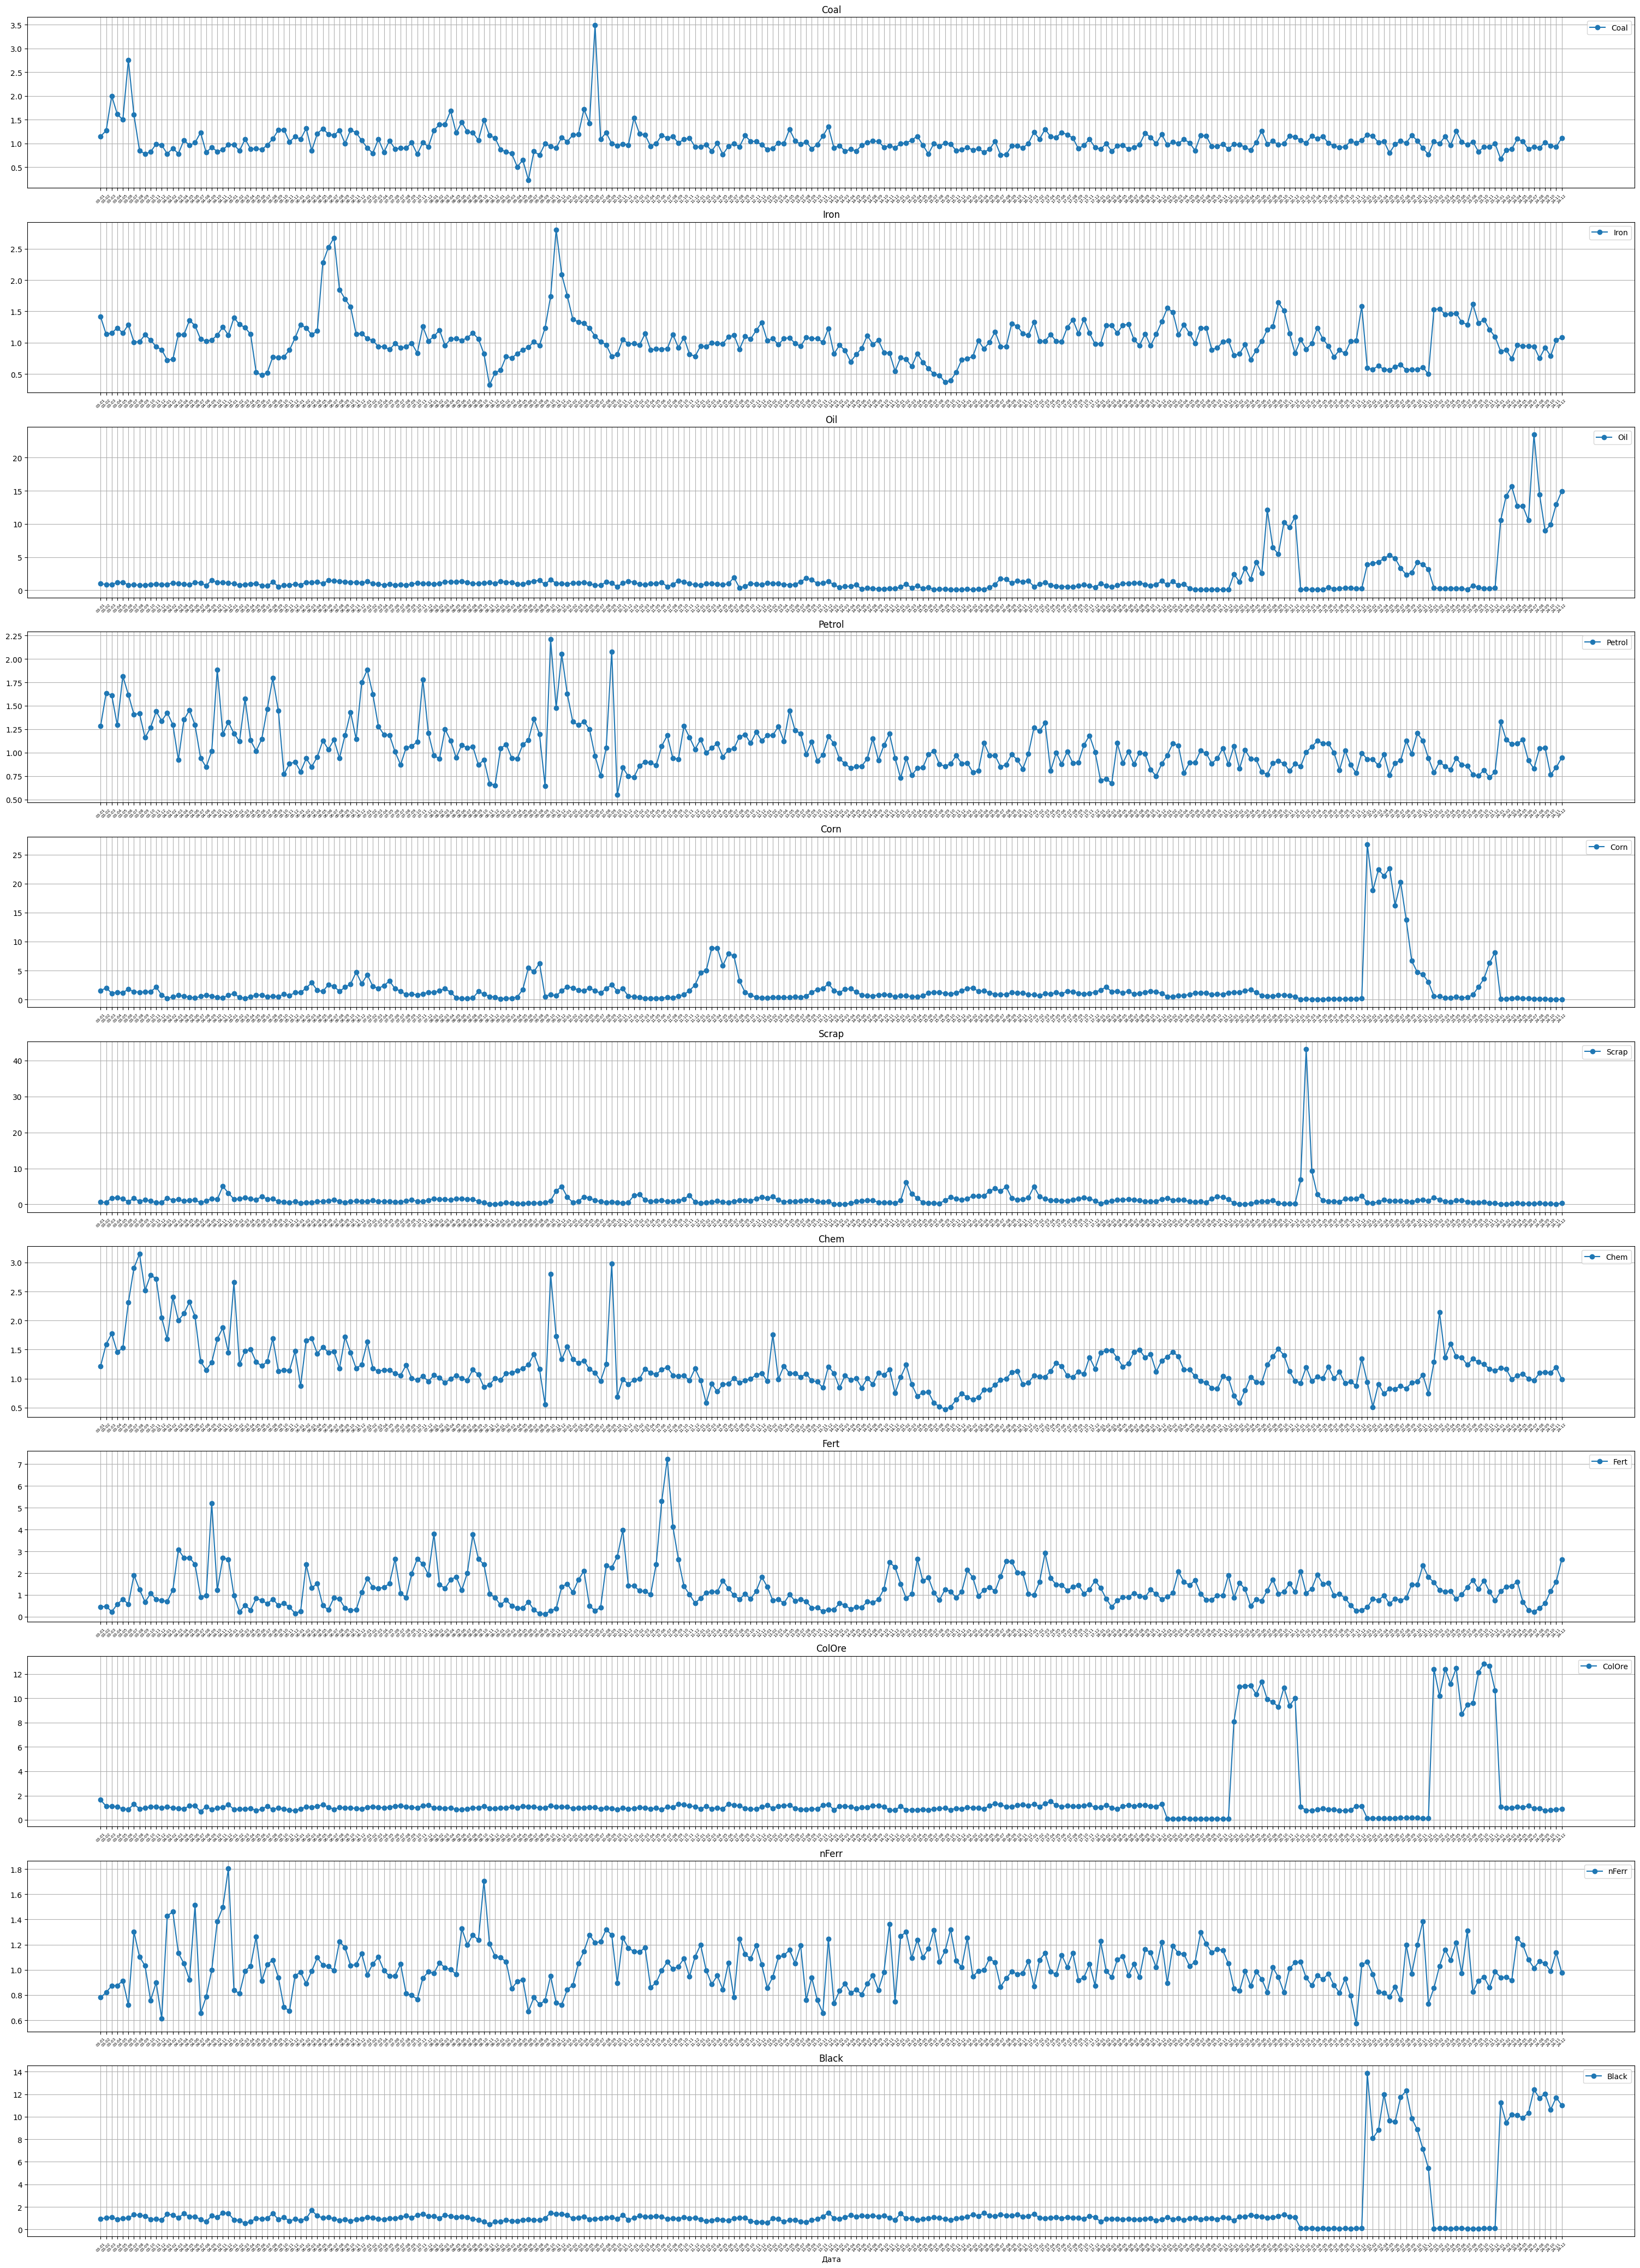

In [24]:
fig, axes = plt.subplots(len(df_transportation_volumes), 1, figsize=(38, 4.8 * len(df_transportation_volumes)), sharex=False)

for ax, cargo in zip(axes, df_transportation_volumes.index):
    ax.plot(df_transportation_volumes.columns, df_transportation_volumes.loc[cargo], marker="o", label=cargo)
    ax.set_title(cargo)
    ax.grid()
    ax.legend()

    step = 1#max(1, len(df_transportation_volumes.columns))  # Количество подписей по X не больше 10
    ax.set_xticks(df_transportation_volumes.columns[::step])
    ax.set_xticklabels(df_transportation_volumes.columns[::step], rotation=45, fontsize=5)  # Красиво форматируем

plt.xlabel("Дата")
plt.show()

### 🐊 Getting indexed adjustment world prices data

In [25]:
url = "https://drive.google.com/uc?id=1a9jJ67D7NGdY-Q5KhyCaAQ7YTGzRXztf"
world_prices = 'world_prices.xlsx'
gdown.download(url, world_prices, quiet=False);

df_world_prices = pd.read_excel(world_prices, index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1a9jJ67D7NGdY-Q5KhyCaAQ7YTGzRXztf
To: /content/world_prices.xlsx
100%|██████████| 26.2k/26.2k [00:00<00:00, 23.0MB/s]


In [26]:
df_world_prices = df_world_prices.rename(columns={date: date.strftime('%y-%m') for date in df_world_prices.columns})

In [27]:
df_world_prices

03-01     03-02     03-03     03-04     03-05     03-06  \
type                                                                         
Coal            0.910420  0.895018  0.877698  0.865713  0.866977  0.967871   
Fert            1.017159  1.065212  1.153134  1.154750  1.166842  1.156018   
nFerr           1.192778  1.264540  1.180530  1.091839  1.153190  1.148635   
Coal_adjusted   0.962963  0.909960  0.888504  0.847205  0.840678  0.925054   
Fert_adjusted   1.053316  1.084912  1.139614  1.142951  1.150161  1.144506   
nFerr_adjusted  1.239561  1.281993  1.163228  1.078401  1.124831  1.140122   

                   03-07     03-08     03-09     03-10  ...     24-03  \
type                                                    ...             
Coal            1.051836  1.138202  1.176211  1.122449  ...  0.702291   
Fert            1.163291  1.119011  1.150806  1.184724  ...  0.820177   
nFerr           1.156215  1.287185  1.328842  1.400018  ...  0.954596   
Coal_adjusted   0.993878  1.083593  1.158128  1.156729  ...  0.680443   
Fert_adjusted   1.153162  1.116617  1.142463  1.173647  ...  0.816779   
nFerr_adjusted  1.149893  1.268218  1.318555  1.394561  ...  0.944875   

                   24-04     24-05     24-06     24-07     24-08     24-09  \
type                                                                         
Coal            0.694719  0.884908  0.969014  0.978099  0.955114  0.856774   
Fert            0.783442  0.832950  1.006068  0.984701  0.892370  0.887433   
nFerr           1.017968  1.125171  1.052769  1.004572  1.043852  1.068782   
Coal_adjusted   0.719036  0.895836  0.975133  0.978947  0.947554  0.813394   
Fert_adjusted   0.799967  0.823795  1.023309  0.986328  0.893193  0.876797   
nFerr_adjusted  1.035108  1.127650  1.047356  1.014701  1.027609  1.051365   

                   24-10     24-11     24-12  
type                                          
Coal            1.031734  1.120643  0.915315  
Fert            0.894911  0.990986  1.007215  
nFerr           1.155891  1.108773  1.088748  
Coal_adjusted   1.017913  1.082100  0.946066  
Fert_adjusted   0.898003  1.005640  1.008464  
nFerr_adjusted  1.120607  1.102526  1.111067  

[6 rows x 264 columns]

🦭 Filter only adjusted rows

In [28]:
# adjusted_rows = [i for i in df_world_prices.index if len(i.split('_')) > 1]

# mask = df_world_prices.index.isin(adjusted_rows)
# df_world_prices = df_world_prices[mask]

In [29]:
# df_world_prices.index = [i.split('_')[0] for i in df_world_prices.index]

In [30]:
df_world_prices

03-01     03-02     03-03     03-04     03-05     03-06  \
type                                                                         
Coal            0.910420  0.895018  0.877698  0.865713  0.866977  0.967871   
Fert            1.017159  1.065212  1.153134  1.154750  1.166842  1.156018   
nFerr           1.192778  1.264540  1.180530  1.091839  1.153190  1.148635   
Coal_adjusted   0.962963  0.909960  0.888504  0.847205  0.840678  0.925054   
Fert_adjusted   1.053316  1.084912  1.139614  1.142951  1.150161  1.144506   
nFerr_adjusted  1.239561  1.281993  1.163228  1.078401  1.124831  1.140122   

                   03-07     03-08     03-09     03-10  ...     24-03  \
type                                                    ...             
Coal            1.051836  1.138202  1.176211  1.122449  ...  0.702291   
Fert            1.163291  1.119011  1.150806  1.184724  ...  0.820177   
nFerr           1.156215  1.287185  1.328842  1.400018  ...  0.954596   
Coal_adjusted   0.993878  1.083593  1.158128  1.156729  ...  0.680443   
Fert_adjusted   1.153162  1.116617  1.142463  1.173647  ...  0.816779   
nFerr_adjusted  1.149893  1.268218  1.318555  1.394561  ...  0.944875   

                   24-04     24-05     24-06     24-07     24-08     24-09  \
type                                                                         
Coal            0.694719  0.884908  0.969014  0.978099  0.955114  0.856774   
Fert            0.783442  0.832950  1.006068  0.984701  0.892370  0.887433   
nFerr           1.017968  1.125171  1.052769  1.004572  1.043852  1.068782   
Coal_adjusted   0.719036  0.895836  0.975133  0.978947  0.947554  0.813394   
Fert_adjusted   0.799967  0.823795  1.023309  0.986328  0.893193  0.876797   
nFerr_adjusted  1.035108  1.127650  1.047356  1.014701  1.027609  1.051365   

                   24-10     24-11     24-12  
type                                          
Coal            1.031734  1.120643  0.915315  
Fert            0.894911  0.990986  1.007215  
nFerr           1.155891  1.108773  1.088748  
Coal_adjusted   1.017913  1.082100  0.946066  
Fert_adjusted   0.898003  1.005640  1.008464  
nFerr_adjusted  1.120607  1.102526  1.111067  

[6 rows x 264 columns]

🕷️ Plot world prices

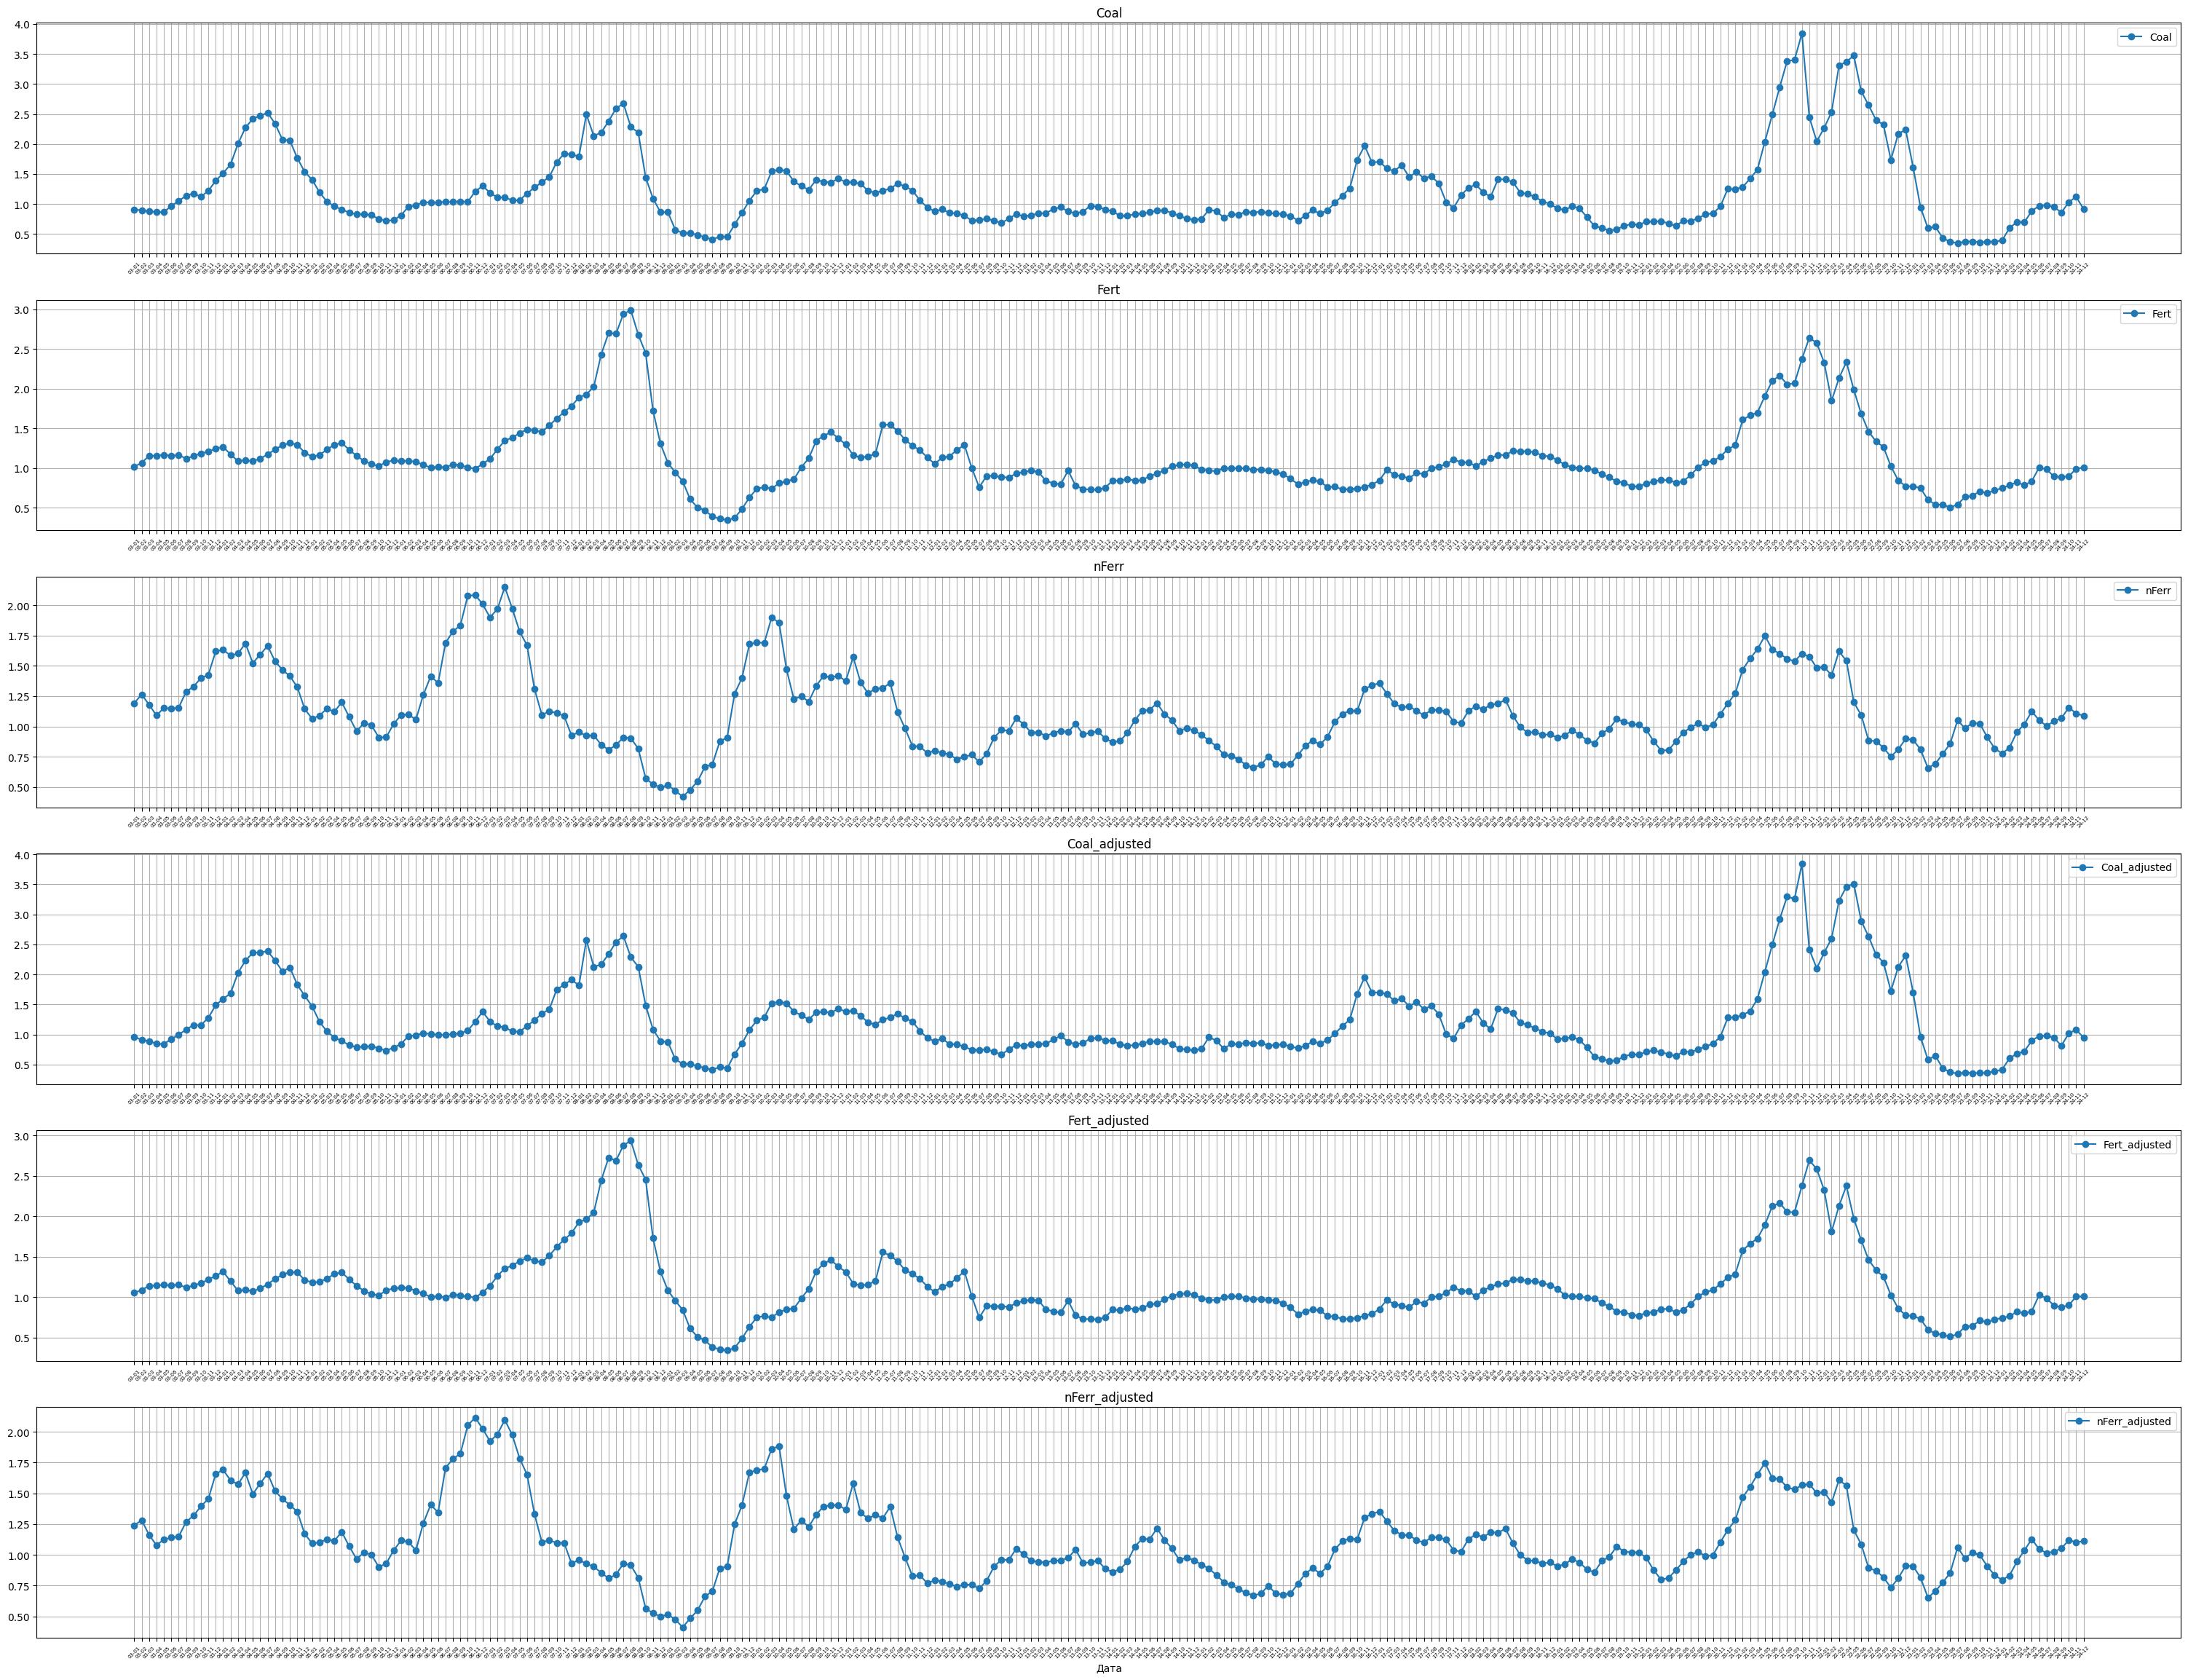

In [31]:
fig, axes = plt.subplots(len(df_world_prices), 1, figsize=(38, 4.8 * len(df_world_prices)), sharex=False)

for ax, cargo in zip(axes, df_world_prices.index):
    ax.plot(df_world_prices.columns, df_world_prices.loc[cargo], marker="o", label=cargo)
    ax.set_title(cargo)
    ax.grid()
    ax.legend()

    step = 1#max(1, len(df_transportation_volumes.columns))  # Количество подписей по X не больше 10
    ax.set_xticks(df_world_prices.columns[::step])
    ax.set_xticklabels(df_world_prices.columns[::step], rotation=45, fontsize=5)  # Красиво форматируем

plt.xlabel("Дата")
plt.show()

🦑 Prepare indexed tariff data

In [32]:
url = "https://drive.google.com/uc?id=1BtFPuxKd6XAhILhfeesl5QnWgZ8o5roO"
tariff = 'tariff.xlsx'
gdown.download(url, tariff, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=1BtFPuxKd6XAhILhfeesl5QnWgZ8o5roO
To: /content/tariff.xlsx
100%|██████████| 2.70M/2.70M [00:00<00:00, 71.2MB/s]


In [33]:
wb = load_workbook(tariff)

main_sheet = 'Тариф'
commodities_transportation_tariffs = {}

In [34]:
end = 2024
column_names = excel_columns(14 * (end - start + 1))

commodities_transportation_tariffs =  fill_transportation_tariffs(wb[main_sheet], start, end)

In [35]:
df_transportation_tariff = pd.DataFrame(commodities_transportation_tariffs)

In [36]:
df_transportation_tariff.head()

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   

   24-04  24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
0    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
1    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
2    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
3    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
4    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   

                 name  
0               уголь  
1       железная руда  
2         нефть сырая  
3       нефтепродукты  
4  строительные грузы  

[5 rows x 277 columns]

In [37]:
dct_names = {'Coal': 'Уголь',
            'Iron': 'Железная руда',
            'Earth': 'Земля, песок, глина и камни природные',
            'Lim': 'Известняк для флюсования',
            'Coke': 'Кокс каменноугольный',
            'Black': 'Чер. металлы',
            'Scrap': 'Лом черных металлов',
            'Wheat': 'Мука пшеничная',
            'Oil': 'Нефть сырая',
            'Petrol': 'Нефтепродукты',
            'Drinks': 'Соки и напитки',
            'Fert': 'Хим. и мин. удобрения',
            'nFerr': 'Цвет. металлы',
            'ColOre': 'Цветная руда',
            'Chem': 'Химикаты и сода',
            'Cement': 'Цемент',
             'Corn': 'Зерно'
            }

In [38]:
for key in dct_names.keys():
  dct_names[key] = " ".join(dct_names[key].replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').lower().split())

In [39]:
common_names = set(dct_names.keys()) & set(df_volumes.index)

### Select data with common names

In [40]:
df_volumes = df_volumes[df_volumes.index.isin(common_names)]

df_transportation_volumes = df_transportation_volumes[df_transportation_volumes.index.isin(common_names)]

In [41]:
df_transportation_tariff['type'] = ''

for idx, row in df_transportation_tariff.iterrows():
  for key in dct_names.keys():
    if dct_names[key] == row['name']:
      df_transportation_tariff.loc[idx, 'type'] = key

In [42]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  ...  \
19    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
10    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   

    24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
19    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
2     0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
0     0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
10    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
17    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   

                    name    type  
19        соки и напитки  Drinks  
2            нефть сырая     Oil  
0                  уголь    Coal  
10          цвет металлы   nFerr  
17  кокс каменноугольный    Coke  

[5 rows x 278 columns]

In [43]:
df_transportation_tariff = df_transportation_tariff[df_transportation_tariff['type'].isin(common_names)]

In [44]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  ...  \
5     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
16    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
19    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   

    24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
5     0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
17    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
0     0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
16    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
19    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   

                    name    type  
5                  зерно    Corn  
17  кокс каменноугольный    Coke  
0                  уголь    Coal  
16        мука пшеничная   Wheat  
19        соки и напитки  Drinks  

[5 rows x 278 columns]

In [45]:
df_transportation_tariff.set_index('type', inplace=True)

In [46]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  \
type                                                                           
ColOre    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
Oil       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
Scrap     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
Earth     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
Coal      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

        ...  24-04  24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
type    ...                                                                  
ColOre  ...    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
Oil     ...    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
Scrap   ...    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
Earth   ...    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
Coal    ...    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   

                                       name  
type                                         
ColOre                         цветная руда  
Oil                             нефть сырая  
Scrap                   лом черных металлов  
Earth   земля песок глина и камни природные  
Coal                                  уголь  

[5 rows x 277 columns]

🐰 Convert all data 2 float

In [47]:
# for column_num in df_transportation_tariff.columns:
#   if column_num != 'name':
#       df_transportation_tariff.loc[:, column_num] = df_transportation_tariff[column_num].astype(float) / 100 + 1.0
for column_num in df_transportation_tariff.columns:
  if column_num != 'name':
      df_transportation_tariff[column_num] = df_transportation_tariff[column_num].astype(float)
      df_transportation_tariff[column_num] = df_transportation_tariff[column_num] / 100 + 1.0

<ipython-input-47-67ac9db9a7ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transportation_tariff[column_num] = df_transportation_tariff[column_num].astype(float)
<ipython-input-47-67ac9db9a7ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transportation_tariff[column_num] = df_transportation_tariff[column_num] / 100 + 1.0
<ipython-input-47-67ac9db9a7ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [48]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  \
type                                                                           
Earth     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Petrol    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Oil       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Chem      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Coke      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   

        ...  24-04  24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
type    ...                                                                  
Earth   ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Petrol  ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Oil     ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Chem    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Coke    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   

                                       name  
type                                         
Earth   земля песок глина и камни природные  
Petrol                        нефтепродукты  
Oil                             нефть сырая  
Chem                        химикаты и сода  
Coke                   кокс каменноугольный  

[5 rows x 277 columns]

🦓 Filter years from 2003

In [49]:
df_transportation_tariff

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  \
type                                                                           
Coal      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.00   
Iron      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Oil       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Petrol    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Corn      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Scrap     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Chem      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Fert      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
ColOre    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
nFerr     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Black     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Cement    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Lim       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Earth     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Wheat     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Coke      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Drinks    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   

        ...  24-04  24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
type    ...                                                                  
Coal    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Iron    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Oil     ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Petrol  ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Corn    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Scrap   ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Chem    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Fert    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
ColOre  ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
nFerr   ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Black   ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Cement  ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Lim     ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Earth   ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Wheat   ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Coke    ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   
Drinks  ...    1.0    1.0  1.088    1.0    1.0    1.0    1.0    1.0  1.078   

                                       name  
type                                         
Coal                                  уголь  
Iron                          железная руда  
Oil                             нефть сырая  
Petrol                        нефтепродукты  
Corn                                  зерно  
Scrap                   лом черных металлов  
Chem                        химикаты и сода  
Fert                    хим и мин удобрения  
ColOre                         цветная руда  
nFerr                          цвет металлы  
Black                           чер металлы  
Cement                               цемент  
Lim                известняк для флюсования  
Earth   земля песок глина и камни природные  
Wheat                        мука пшеничная  
Coke                   кокс каменноугольный  
Drinks                       соки и напитки  

[17 rows x 277 columns]

In [50]:
df_transportation_tariff = df_transportation_tariff[df_transportation_volumes.columns]

In [51]:
df_transportation_tariff.loc['Coal', '10-01']

1.2153

# 🦚 Run regression model

## 🦤 Prepare data to model

In [52]:
import warnings
warnings.filterwarnings("ignore")

### 🦧 Prepare SERial data

In [62]:
dct_serial = {
    #'Coal': ["SER0306", "SER0406", "SER1006", "SER1311", "SER1312", "SER1412", "SER1501", "SER1510", "SER1706"],
    'Coal': ["SER0306", "SER1006"],
    #'Iron': ["SER0505", "SER0604", "SER0605", "SER0606", "SER0607", "SER0608", "SER0705", "SER0811", "SER0910", "SER0911", "SER0912", "SER1001", "SER1004", "SER1312", "SER1401", "SER1501", "SER1507", "SER1509", "SER1705", "SER1706", "SER1707"],
    'Iron': ["SER0605", "SER0608", "SER0911", "SER0912",  "SER1004", "SER1401", "SER1501"],
    'Oil': ["SER0402", "SER0409", "SER0601", "SER0602", "SER0603", "SER0608", "SER0610", "SER1207", "SER1208", "SER1311", "SER1404", "SER1607", "SER1703", "SER1708"],
    'Petrol': ["SER0405", "SER0510", "SER0706", "SER0912", "SER1009", "SER1212", "SER1401", "SER1501", "SER1505", "SER1603", "SER1604", "SER2206", "SER2401", "SER2407"],
    #'Petrol': ["SER0510", "SER0912", "SER1009", "SER2401"],
    'Constr': ["SER0501", "SER0803", "SER0811", "SER1002", "SER1011", "SER1103", "SER1301", "SER1401", "SER1502", "SER1602", "SER170"],
    'Chem': ["SER0307", "SER0910", "SER0911", "SER1009", "SER1010", "SER1302", "SER1303", "SER2302"],
    #'Chem': ["SER0307", "SER0411", "SER0807", "SER0901", "SER0903", "SER0904", "SER0905", "SER0909", "SER0910", "SER0911", "SER1001", "SER1009", "SER1010", "SER1104", "SER1302", "SER1303", "SER1401", "SER1501", "SER1611", "SER1901", "SER2002", "SER2201", "SER2212", "SER2302"],
    'Black': ["SER0603", "SER1101", "SER1501", "SER1701"],
    'Cement': ["SER0411", "SER0501", "SER0808", "SER1001", "SER1004", "SER1006", "SER1007", "SER1008", "SER1011", "SER1312", "SER1501", "SER1701"],
    'Coke': ["SER0501", "SER0701", "SER0710", "SER0901", "SER1003", "SER1004", "SER1012", "SER1102", "SER1201", "SER1203", "SER1204", "SER1409", "SER1412", "SER1501", "SER1703", "SER1707"],
    'ColOre': ["SER0407", "SER0501", "SER0901", "SER1001", "SER1206", "SER1302", "SER1312", "SER1401", "SER1402", "SER1501", "SER1502", "SER1505", "SER1606"],
    'Corn': ["SER0603", "SER0604", "SER0611", "SER0708", "SER0906", "SER0908", "SER0909", "SER0910", "SER1104", "SER1201", "SER1203", "SER1208", "SER1209", "SER1210", "SER1501", "SER1507"],
    'Drinks': ["SER0401", "SER0508", "SER0701", "SER0801", "SER1009", "SER1104", "SER1306", "SER1312", "SER1401", "SER1501", "SER1509"],
    'Earth': ["SER0401", "SER0503", "SER0704", "SER0710", "SER0812", "SER0903", "SER1002", "SER1101", "SER1301", "SER1401", "SER1403", "SER1501", "SER1503", "SER1505", "SER1701"],
    #'Fert': ["SER0409", "SER0510", "SER0511", "SER0702", "SER0810", "SER1010", "SER1011", "SER1107", "SER1201", "SER1710"],
    'Fert': ["SER0409", "SER0510", "SER0511", "SER0702", "SER0810", "SER1010", "SER1011", "SER1107", "SER1201", "SER1710", "SER1911", "SER2109", "SER2410"],
    'Lim': ["SER0702", "SER1002", "SER1003", "SER1010", "SER1011", "SER1102", "SER1312", "SER1401", "SER1501", "SER1701", "SER1711"],
    #'nFerr': ['SER0511', 'SER0709', 'SER1004', 'SER2404', 'SER0704', 'SER1710', 'SER1601', 'SER0603', 'SER0912', 'SER1504', 'SER0806', 'SER0405', 'SER2107', 'SER1412', 'SER2312', 'SER0406', 'SER2212', 'SER1207', 'SER0906', 'SER2307', 'SER0810'],
    #'nFerr': ["SER0405", "SER0406", "SER0511", "SER0602", "SER0603", "SER0704", "SER0709", "SER0806", "SER0810", "SER0906", "SER0912", "SER1001", "SER1004", "SER1005", "SER1207", "SER1401", "SER1405", "SER1412", "SER1501", "SER1504", "SER1601", "SER1709", "SER1710", "SER1712", "SER2107", "SER2111", "SER2212", "SER2307", "SER2312", "SER2404"],
    #'nFerr': ["SER0406","SER0806", "SER0810", "SER0906", "SER1401", "SER1412", "SER1501", "SER1601", "SER2111", "SER2212", "SER2307", "SER2404"],
    'nFerr': ["SER0406", "SER0806", "SER0810", "SER2212"],
    'Other': ["SER0912", "SER1007", "SER1012", "SER1312", "SER1401", "SER1501"],
    #'Scrap': ["SER0401", "SER0404", "SER0405", "SER0406", "SER0407", "SER0411", "SER0603", "SER0604", "SER0810", "SER0910", "SER0911", "SER0912", "SER1101", "SER1111", "SER1502", "SER1606", "SER1608", "SER1701", "SER1702", "SER2102", "SER1912", "SER2111", "SER2406"],
    'Scrap': ["SER0401", "SER0411", "SER0911", "SER0912", "SER1111", "SER1502", "SER1606", "SER1608", "SER1701",  "SER2102"],
    'Slag': ["SER0402", "SER0704", "SER0705", "SER0707", "SER0708", "SER0911", "SER1001", "SER1101", "SER1102", "SER1109", "SER1110", "SER1511", "SER1601", "SER1612"],
    'Wheat': ["SER0806", "SER0912", "SER1201", "SER1403"],
    #'Corn': ["SER0603", "SER0604", "SER0611", "SER0708", "SER0906", "SER0908", "SER0909", "SER0910", "SER1104", "SER1201", "SER1203", "SER1208", "SER1209","SER1210", "SER1501", "SER1507"]
    #'Corn': ["SER0801", "SER0901","SER1001","SER1101","SER1201","SER1301","SER1401","SER2001","SER2101","SER2201","SER2301","SER2401"],
    #'Corn': ["SER0806", "SER0809","SER1202","SER1205", "SER1401","SER2201", "SER2202","SER2203", "SER2206","SER2207", "SER2208","SER2209"],
    'Corn': ["SER1401","SER2201"],
}

### 🦇 Corn

**********************************************************************************
commodity type: Corn


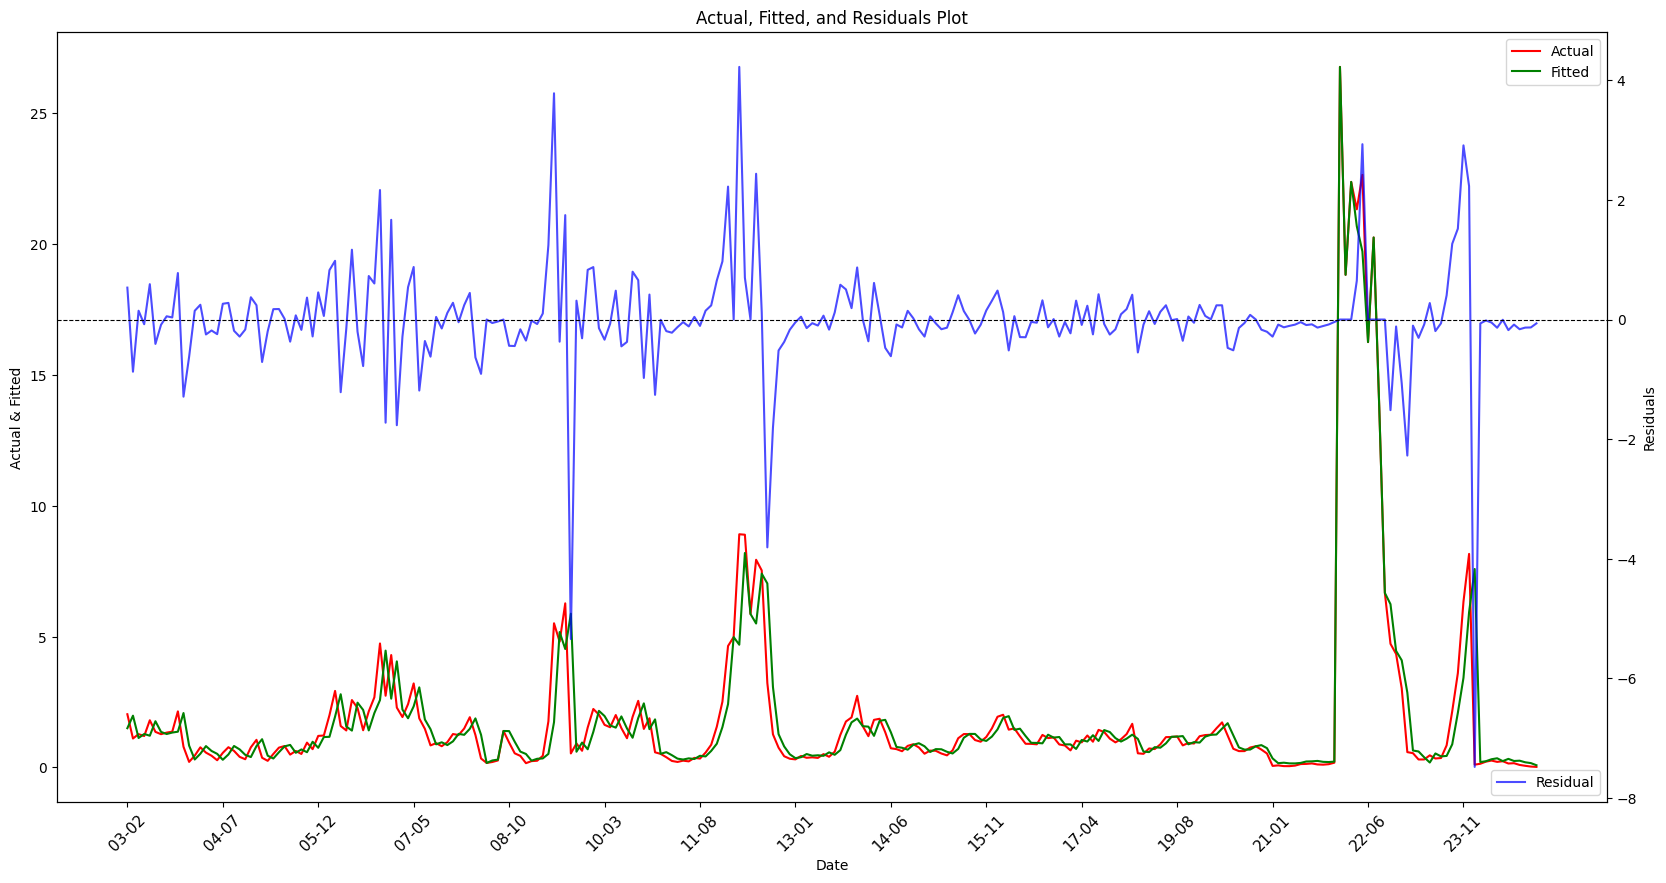

                            OLS Regression Results                            
Dep. Variable:                   V_SA   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     236.7
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          1.50e-130
Time:                        06:42:36   Log-Likelihood:                -346.88
No. Observations:                 252   AIC:                             723.8
Df Residuals:                     237   BIC:                             776.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8183      1.633      0.501      0.6

In [64]:
commodity_type = 'Corn'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"M_SA": df_volumes.loc[commodity_type],   # Production growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

df_type = df_type.dropna()

Y = df_type["V_SA"]
lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

In [ ]:
# ! apt install x13as

In [ ]:
# date_rng = pd.date_range(start='2003-02-01', periods=264, freq='M')
# date_rng

In [ ]:
# df_sa = pd.DataFrame(df_transportation_volumes.loc[commodity_type])
# df_sa.index = date_rng

In [ ]:
# res = sm.tsa.x13_arima_analysis(df_sa, freq='M')

# adjusted_series = res.seasadj

# adjusted_series.to_excel(f"{commodity_type}.xlsx")

In [ ]:
commodity_type = 'Corn'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 20)
d_values = range(0, 4)
q_values = range(0, 20)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("EXP_T", None)
        pval_T = results.pvalues.get("EXP_T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results
            print(p, d, q)
            print(results.summary())

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
SER2201        1.3372      0.146      9.151      0.000       1.051       1.624
V_SA(-1)       0.0427      0.004     10.388      0.000       0.035       0.051
ar.L1          0.1355      1.102      0.123      0.902      -2.025       2.296
ar.L2         -0.5169      0.877     -0.589      0.556      -2.237       1.203
ar.L3         -0.2198      0.842     -0.261      0.794      -1.869       1.430
ar.L4         -0.3858      1.142     -0.338      0.736      -2.625       1.853
ar.L5         -0.0425      0.576     -0.074      0.941      -1.172       1.087
ar.L6         -0.1965      0.455     -0.432      0.666      -1.088       0.695
ar.L7         -0.0616      0.524     -0.118      0.906      -1.089       0.966
ar.L8         -0.3524      0.321     -1.097      0.273      -0.982       0.277
ar.L9         -0.0415      0.419     -0.099      0.921      -0.862       0.779
ar.L10        -0.1758      0.226     -0.778      0.436      -0.618       0.267
m

4 0 4
                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(4, 0, 4)   Log Likelihood                  20.096
Date:                Tue, 25 Feb 2025   AIC                            -12.191
Time:                        06:44:24   BIC                             36.940
Sample:                             0   HQIC                             7.590
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXP_T         -0.0490      0.020     -2.486      0.013      -0.088      -0.010
M_SA           0.9788      0.004    269.144      0.000       0.972       0.986
SER1401        0.4415      0.155      2.852   

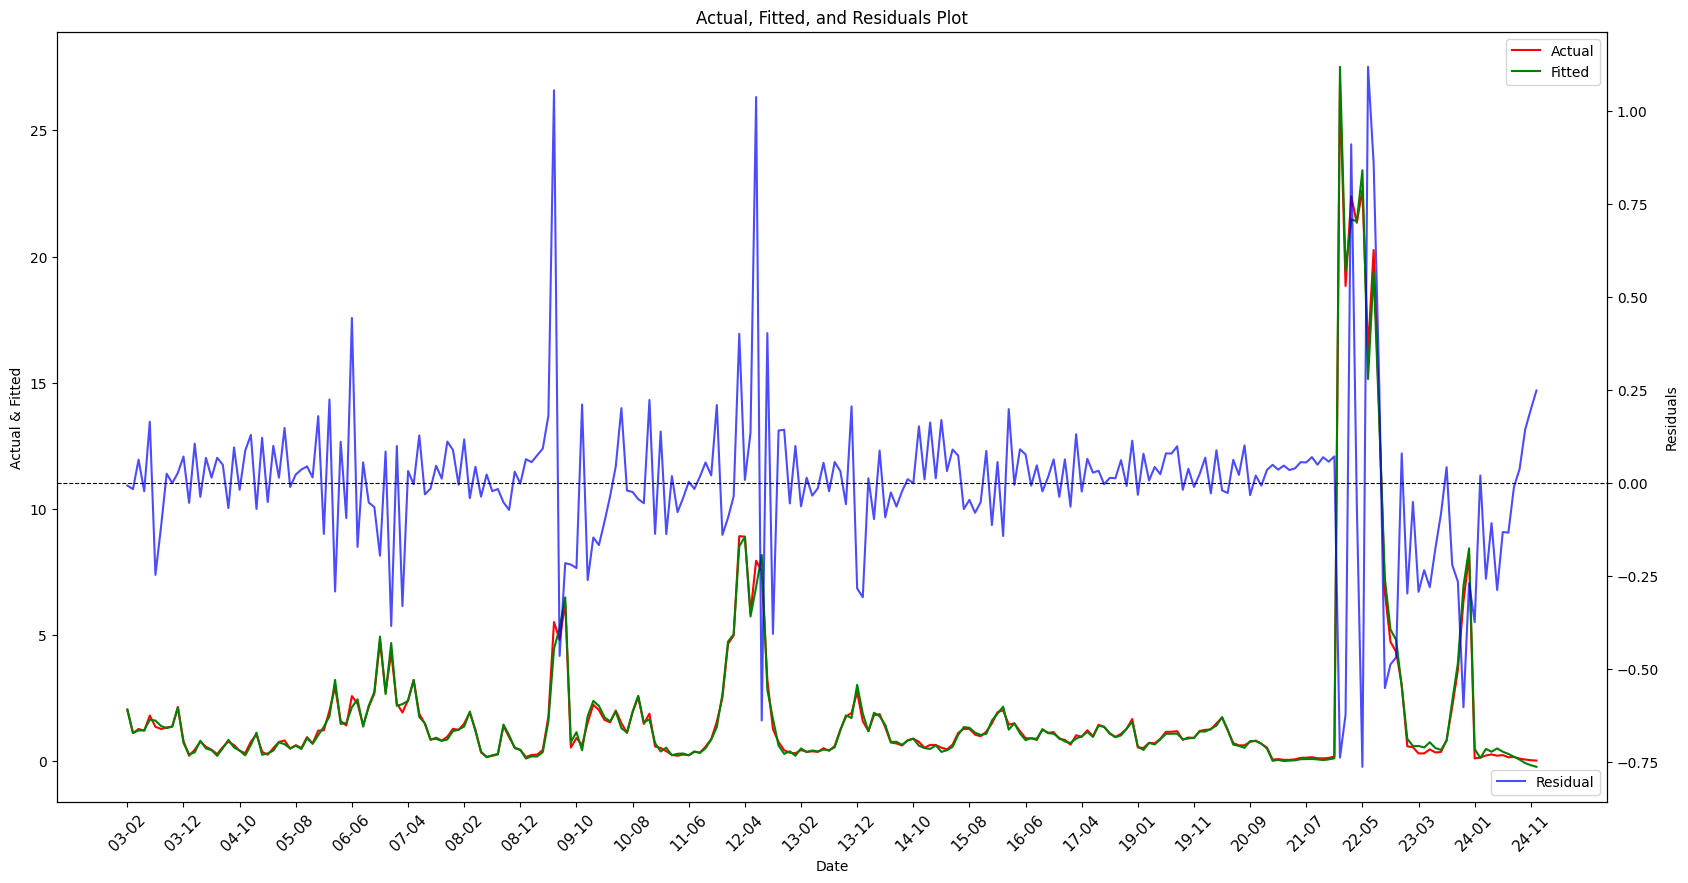

In [68]:
commodity_type = 'Corn'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную
#p, d, q = 1, 0, 7
p, d, q = 4, 0, 4
model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

print(p, d, q)
print(results.summary())
plot_regression_results(results, df_type)

### 🕷️ Iron

**********************************************************************************
commodity type: Iron


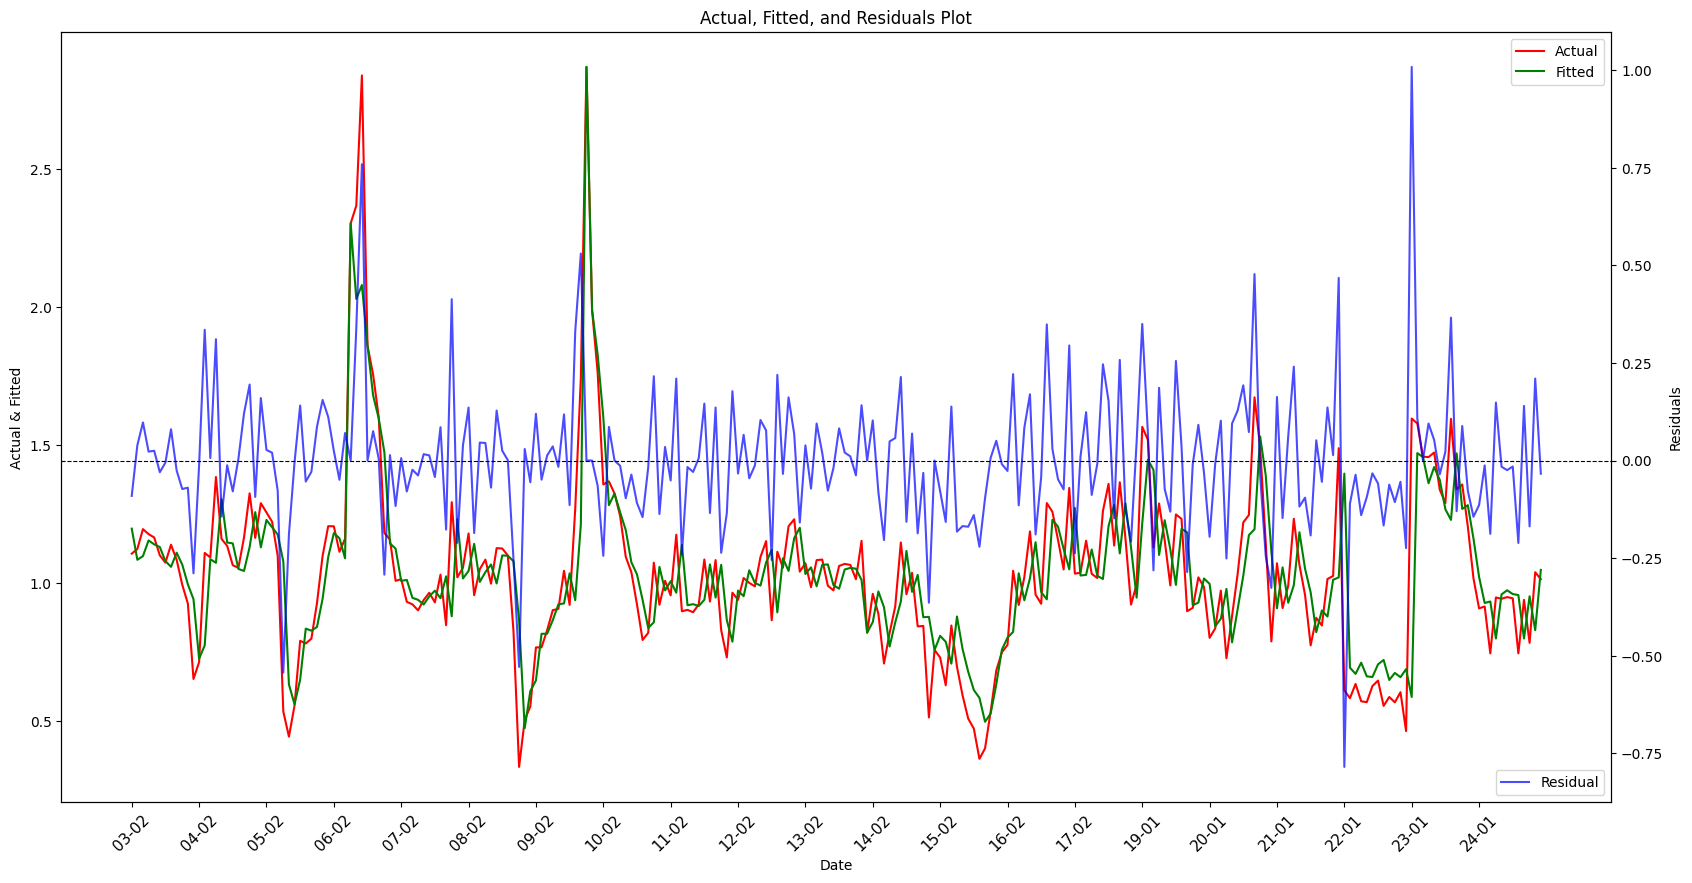

                                 OLS Regression Results                                
Dep. Variable:                   V_SA   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              954.9
Date:                Sun, 23 Feb 2025   Prob (F-statistic):                   3.92e-184
Time:                        16:19:36   Log-Likelihood:                          72.789
No. Observations:                 252   AIC:                                     -127.6
Df Residuals:                     243   BIC:                                     -95.81
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# commodity_type = 'Iron'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     #"M_SA": df_volumes.loc[commodity_type],   # Production growth index
#     #"P": df_world_prices.loc[commodity_type]   # World prices growth index
# }
# # dummy variables
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#   type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

# df_type = df_type.dropna()

# Y = df_type["V_SA"]
# lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
# X = df_type[[i for i in df_type.columns if i in lst_data]]
# df_type.set_index('date', inplace=True)
# # Adding a constant for regression
# #X = sm.add_constant(X)

# # Make regression
# model = sm.OLS(Y, X).fit()

# print("**********************************************************************************")
# print("commodity type:", commodity_type)

# # correlation_matrix = df_type.corr()
# # print(correlation_matrix)
# # Print results
# plot_regression_results(model, df_type)
# print(model.summary())

🐱 Select features

In [ ]:
# commodity_type = 'Iron'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
# }

# # Добавляем dummy-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# # Добавляем лаг переменной Y
# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

# # Удаляем строки с пропущенными значениями
# df_type = df_type.dropna()

# # Определяем зависимую переменную
# Y = df_type["V_SA"]

# # Обязательные переменные
# mandatory_features = ["EXP_T", "V_SA(-1)"]

# # Все возможные дополнительные переменные (кроме "Y" и "date")
# optional_features = [col for col in df_type.columns if col not in ["V_SA", "date"] and col not in mandatory_features]

# best_model = None
# best_adj_r2 = -np.inf  # Максимизируем скорректированный R²
# best_features = None

# # Перебираем все возможные комбинации дополнительных признаков
# flag = False
# for r in tqdm(range(len(optional_features) + 1)):  # От 0 до всех возможных переменных
#     for subset in itertools.combinations(optional_features, r):
#         selected_features = list(mandatory_features) + list(subset)
#         X = df_type[selected_features]

#         # Строим регрессию
#         model = sm.OLS(Y, X).fit()

#         # Проверяем условия
#         if model.pvalues["EXP_T"] < 0.1 and model.pvalues["V_SA(-1)"] < 0.1 and model.params["EXP_T"] < 0:
#             best_model = model
#             best_features = selected_features
#             flag = True
#             break
#             # Выбираем модель с наибольшим скорректированным R²
#             # if model.rsquared_adj > best_adj_r2:
#             #     best_model = model
#             #     best_adj_r2 = model.rsquared_adj
#             #     best_features = selected_features
#     if flag:
#         break
# # Выводим результаты лучшей модели
# if best_model:
#     print("Лучшая модель:")
#     print(f"Выбранные переменные: {best_features}")
#     print(best_model.summary())
# else:
#     print("Не найдено моделей, удовлетворяющих условиям.")

  0%|          | 0/9 [00:00<?, ?it/s]

Не найдено моделей, удовлетворяющих условиям.


0it [00:00, ?it/s]

Лучшие параметры SARIMAX: (2, 2, 2)
                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(2, 2, 2)   Log Likelihood                  46.898
Date:                Sun, 23 Feb 2025   AIC                            -63.796
Time:                        18:20:28   BIC                            -11.155
Sample:                             0   HQIC                           -42.603
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXP_T         -0.5651      0.247     -2.287      0.022      -1.050      -0.081
M_SA           0.0234      0.015      1.513      0.130      -0.007       0.054
SER0605        1

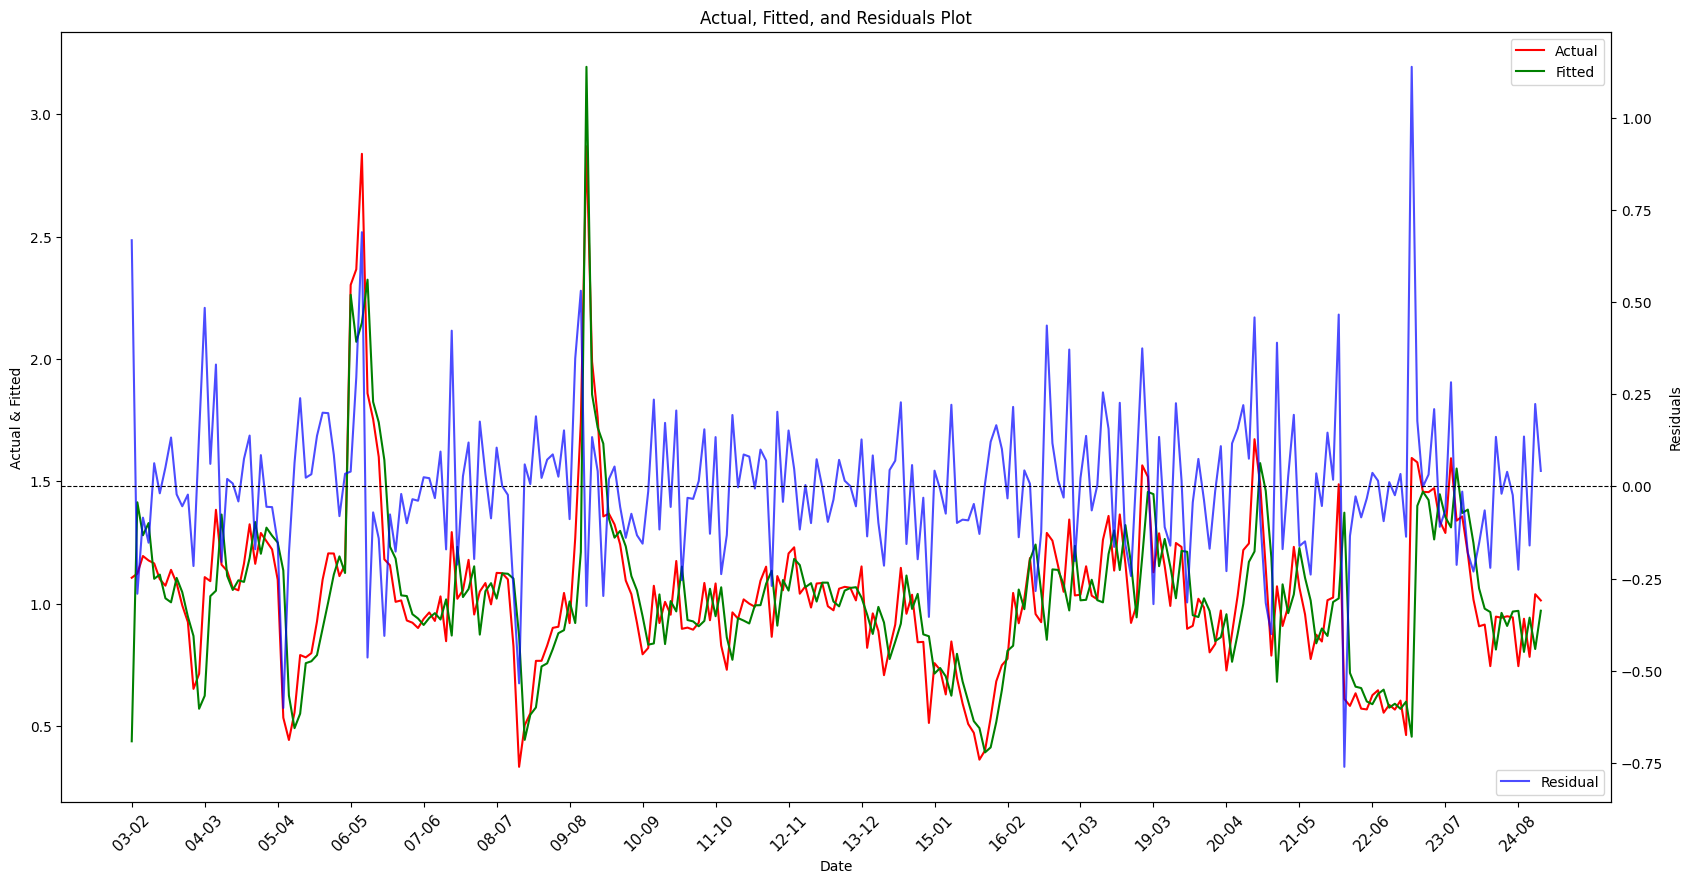

In [ ]:
# commodity_type = 'Iron'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
# }

# # Dummy-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
# df_type = df_type.dropna()
# df_type.set_index('date', inplace=True)

# # Целевая переменная и регрессоры
# Y = df_type["V_SA"]
# X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# # Подбор оптимальных p, d, q
# p_values = range(0, 20)
# d_values = range(0, 5)
# q_values = range(0, 20)

# best_aic = float("inf")
# best_order = None
# best_model = None

# for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
#     try:
#         model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
#                                           enforce_stationarity=False, enforce_invertibility=False)
#         results = model.fit(disp=False)

#         # Достаем коэффициент и p-value для "T"
#         coef_T = results.params.get("EXP_T", None)
#         pval_T = results.pvalues.get("EXP_T", None)

#         # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
#         if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = (p, d, q)
#                 best_model = results

#     except:
#         continue

# # Вывод результатов
# if best_model:
#     print(f"Лучшие параметры SARIMAX: {best_order}")
#     print(best_model.summary())
#     plot_regression_results(best_model, df_type)
# else:
#     print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

### 🐀 Coal

**********************************************************************************
commodity type: Coal


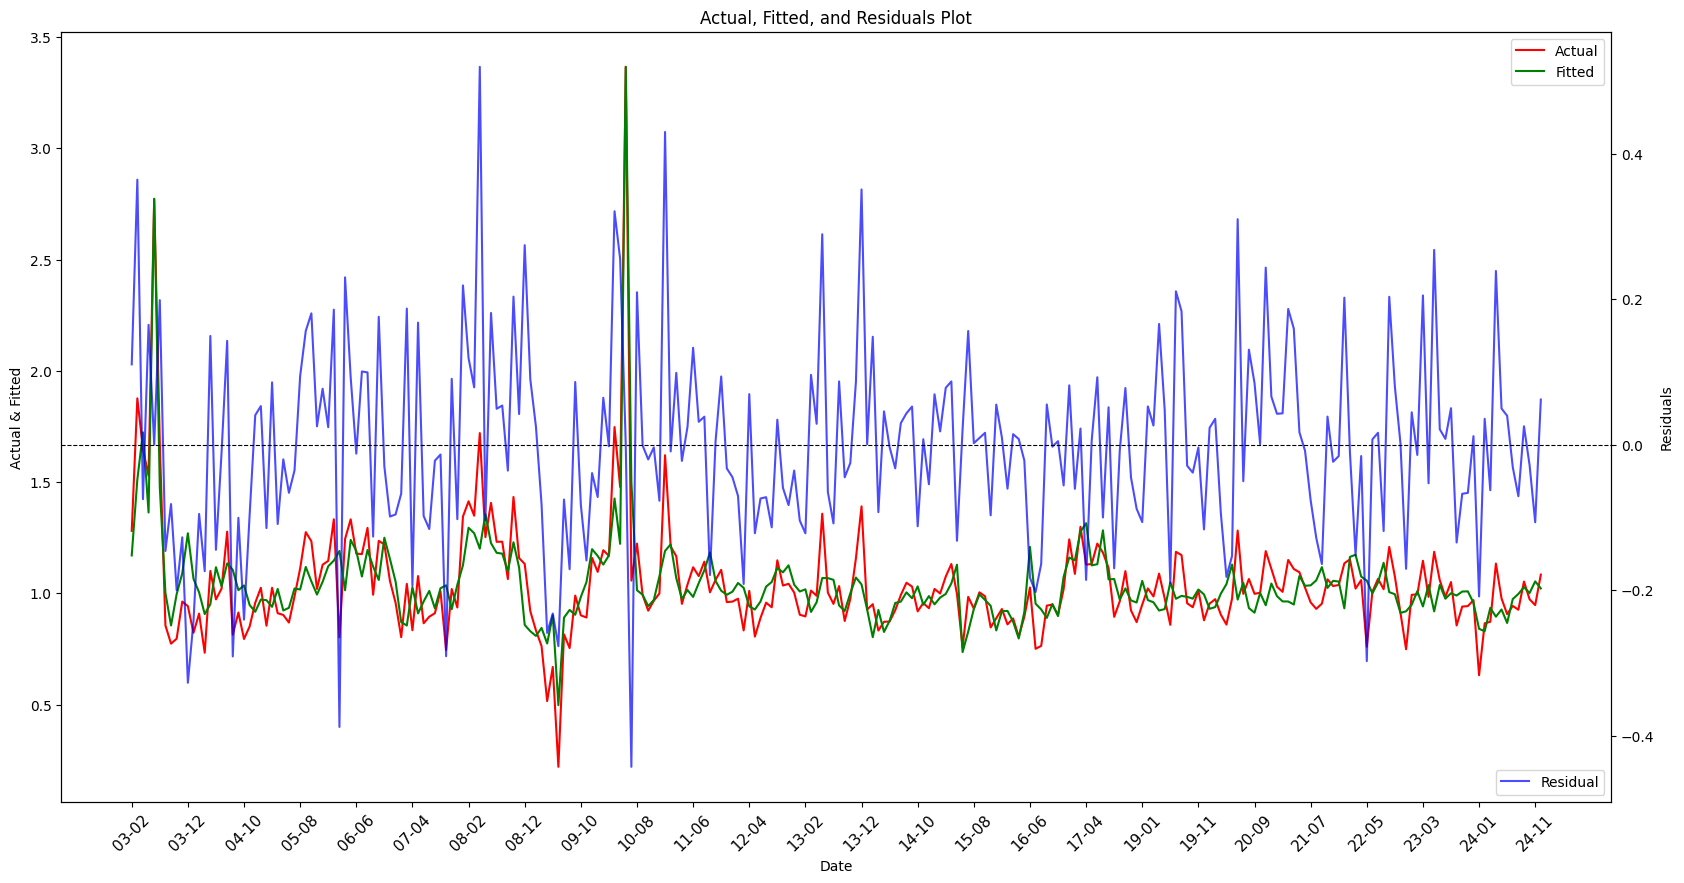

                                 OLS Regression Results                                
Dep. Variable:                   V_SA   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              3024.
Date:                Sun, 23 Feb 2025   Prob (F-statistic):                   2.96e-219
Time:                        18:20:29   Log-Likelihood:                          144.34
No. Observations:                 252   AIC:                                     -278.7
Df Residuals:                     247   BIC:                                     -261.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# commodity_type = 'Coal'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
#     #"P": df_world_prices.loc[commodity_type]   # World prices growth index
# }
# # dummy variables
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#   type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

# df_type = df_type.dropna()

# Y = df_type["V_SA"]
# lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
# X = df_type[[i for i in df_type.columns if i in lst_data]]
# df_type.set_index('date', inplace=True)
# # Adding a constant for regression
# #X = sm.add_constant(X)

# # Make regression
# model = sm.OLS(Y, X).fit()

# print("**********************************************************************************")
# print("commodity type:", commodity_type)

# # correlation_matrix = df_type.corr()
# # print(correlation_matrix)
# # Print results
# plot_regression_results(model, df_type)
# print(model.summary())

### 🦊 Petrol

**********************************************************************************
commodity type: Petrol


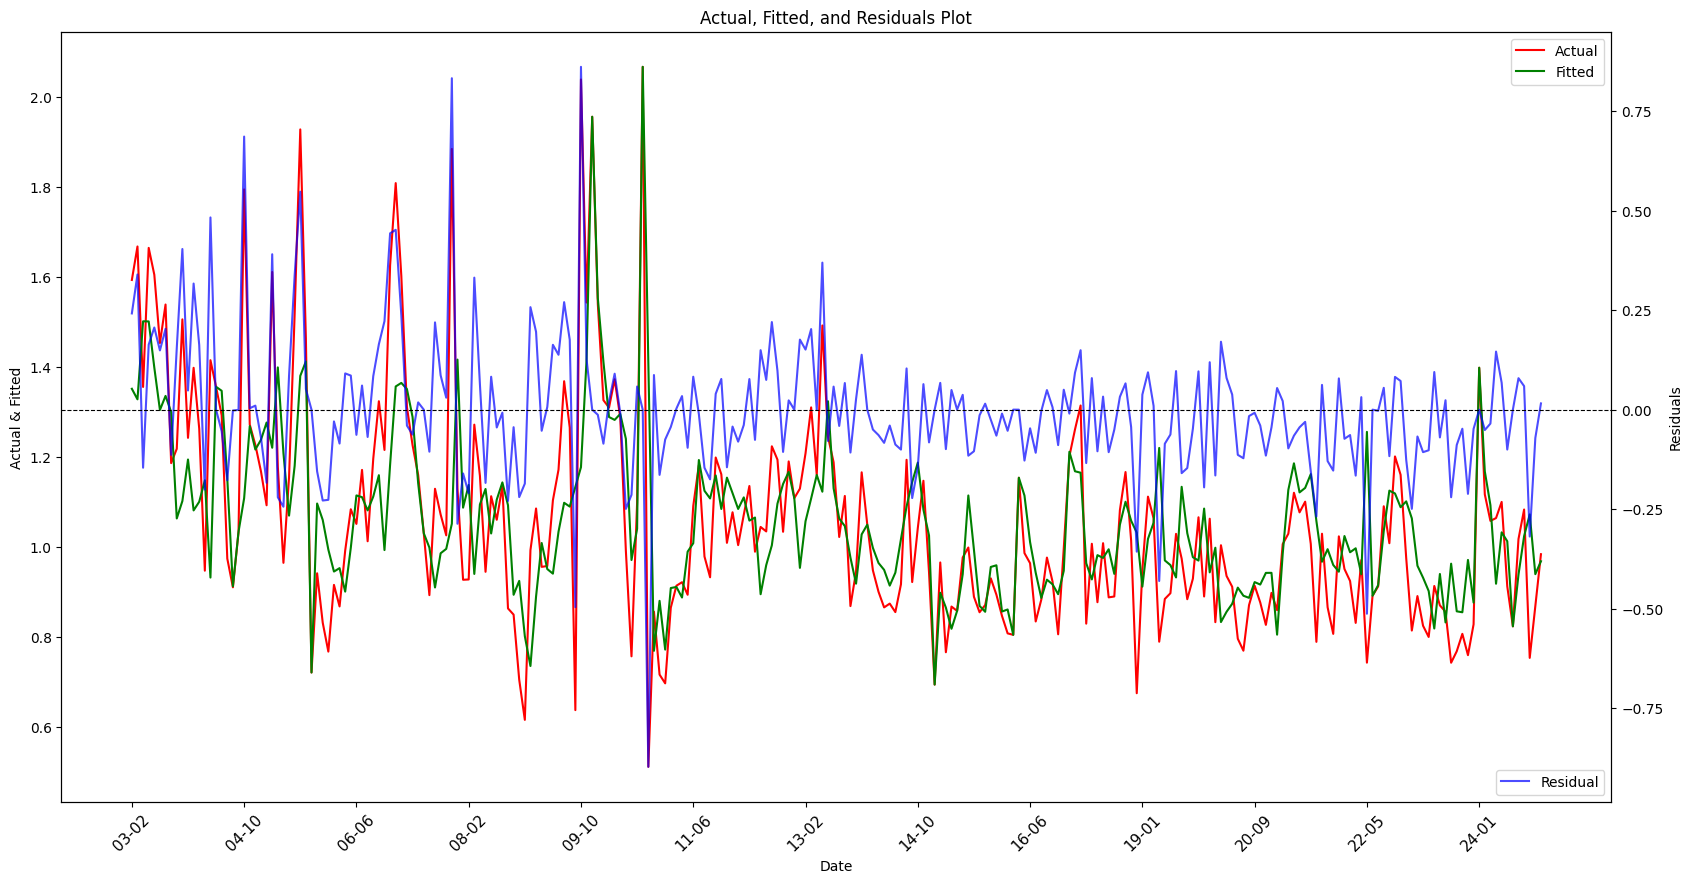

                            OLS Regression Results                            
Dep. Variable:                   V_SA   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     12.81
Date:                Sun, 23 Feb 2025   Prob (F-statistic):           4.99e-25
Time:                        18:20:30   Log-Likelihood:                 68.754
No. Observations:                 252   AIC:                            -101.5
Df Residuals:                     234   BIC:                            -37.98
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5167      0.313      1.649      0.1

In [ ]:
commodity_type = 'Petrol'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

df_type = df_type.dropna()

Y = df_type["V_SA"]
lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

In [ ]:
commodity_type = 'Petrol'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 20)
d_values = range(0, 2)
q_values = range(0, 20)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("T", None)
        pval_T = results.pvalues.get("T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Не удалось найти подходящую модель, удовлетворяющую условиям.


### 🦡 Scrap

In [ ]:
commodity_type = 'Scrap'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную
#X = sm.add_constant(X)
# Подбор оптимальных p, d, q
p_values = range(0, 10)
d_values = range(0, 5)
q_values = range(0, 10)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("EXP_T", None)
        pval_T = results.pvalues.get("EXP_T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

Не удалось найти подходящую модель, удовлетворяющую условиям.


### 🦏 Chem

In [ ]:
# commodity_type = 'Chem'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type]   # Production growth index
# }
# # dummy variables
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#   type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

# df_type = df_type.dropna()

# Y = df_type["V_SA"]
# lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
# X = df_type[[i for i in df_type.columns if i in lst_data]]
# df_type.set_index('date', inplace=True)
# # Adding a constant for regression
# #X = sm.add_constant(X)

# # Make regression
# model = sm.OLS(Y, X).fit()

# print("**********************************************************************************")
# print("commodity type:", commodity_type)

# # correlation_matrix = df_type.corr()
# # print(correlation_matrix)
# # Print results
# plot_regression_results(model, df_type)
# print(model.summary())

In [ ]:
# # Исходные данные
# commodity_type = 'Chem'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
# }

# # Dummy-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
# df_type = df_type.dropna()
# df_type.set_index('date', inplace=True)

# # Целевая переменная и регрессоры
# Y = df_type["V_SA"]
# X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# # Подбор оптимальных p, d, q
# p_values = range(0, 10)
# d_values = range(0, 2)
# q_values = range(0, 10)

# best_aic = float("inf")
# best_order = None
# best_model = None

# for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
#     try:
#         model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
#                                           enforce_stationarity=False, enforce_invertibility=False)
#         results = model.fit(disp=False)

#         # Достаем коэффициент и p-value для "T"
#         coef_T = results.params.get("EXP_T", None)
#         pval_T = results.pvalues.get("EXP_T", None)

#         # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
#         if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = (p, d, q)
#                 best_model = results

#     except:
#         continue

# # Вывод результатов
# if best_model:
#     print(f"Лучшие параметры SARIMAX: {best_order}")
#     print(best_model.summary())
#     plot_regression_results(best_model, df_type)
# else:
#     print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

In [ ]:
# # Исходные данные
# commodity_type = 'Chem'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
# }

# # Dummy-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
# df_type = df_type.dropna()
# df_type.set_index('date', inplace=True)

# # Целевая переменная и регрессоры
# Y = df_type["V_SA"]
# X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# # Подбор оптимальных p, d, q
# p_values = range(0, 10)
# d_values = range(0, 2)
# q_values = range(0, 10)

# best_aic = float("inf")
# best_order = None
# best_model = None

# for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
#     try:
#         model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
#                                           enforce_stationarity=False, enforce_invertibility=False)
#         results = model.fit(disp=False)

#         # Достаем коэффициент и p-value для "T"
#         coef_T = results.params.get("EXP_T", None)
#         pval_T = results.pvalues.get("EXP_T", None)

#         # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
#         if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.05:
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_order = (p, d, q)
#                 best_model = results

#     except:
#         continue

# # Вывод результатов
# if best_model:
#     print(f"Лучшие параметры SARIMAX: {best_order}")
#     print(best_model.summary())
#     plot_regression_results(best_model, df_type)
# else:
#     print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

### 🐕 Fert

In [ ]:
commodity_type = 'Fert'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

df_type = df_type.dropna()

Y = df_type["V_SA"]
lst_data = [i for i in df_type.columns if i != 'Y' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]


# Вычисляем VIF для каждой переменной в X
X_vif = X.copy()  # X — это твоя матрица признаков без Y и даты
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

df_type.set_index('date', inplace=True)
# Adding a constant for regression
#X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
plot_regression_results(model, df_type)
print(model.summary())

In [ ]:
commodity_type = 'Fert'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# Подбор оптимальных p, d, q
p_values = range(0, 25)
d_values = range(0, 5)
q_values = range(0, 25)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("T", None)
        pval_T = results.pvalues.get("T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

0it [00:00, ?it/s]

In [ ]:
# from sklearn.metrics import mean_squared_error

# # Исходные данные
# commodity_type = 'Chem'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
# }

# # Dummy-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
# df_type = df_type.dropna()
# df_type.set_index('date', inplace=True)

# # Целевая переменная и регрессоры
# Y = df_type["V_SA"]
# X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную

# # Подбор оптимальных p, d, q
# p_values = range(0, 4)
# d_values = range(0, 2)
# q_values = range(0, 4)

# best_aic = float("inf")
# best_order = None
# best_model = None

# for p, d, q in itertools.product(p_values, d_values, q_values):
#     try:
#         model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
#                                           enforce_stationarity=False, enforce_invertibility=False)
#         results = model.fit(disp=False)

#         if results.aic < best_aic:
#             best_aic = results.aic
#             best_order = (p, d, q)
#             best_model = results
#     except:
#         continue

# # Вывод результатов
# print(f"Лучшие параметры SARIMAX: {best_order}")
# print(best_model.summary())
# plot_regression_results(best_model, df_type)


In [ ]:
# from sklearn.linear_model import Ridge
# from sklearn.preprocessing import StandardScaler

# # Масштабируем признаки (Ridge чувствителен к масштабу данных)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)  # X — твоя матрица признаков без Y и даты

# # Обучаем Ridge-регрессию (альфа — параметр регуляризации)
# ridge_model = Ridge(alpha=0.01)  # Можно подобрать alpha через кросс-валидацию
# ridge_model.fit(X_scaled, Y)

# # Выводим коэффициенты
# print("Коэффициенты Ridge-регрессии:")
# print(dict(zip(X.columns, ridge_model.coef_)))

# # R² Ridge-регрессии
# print(f"R² модели: {ridge_model.score(X_scaled, Y):.4f}")

In [ ]:
# from sklearn.model_selection import GridSearchCV

# alphas = [0.01, 0.1, 1, 10, 100]
# ridge_cv = GridSearchCV(Ridge(), param_grid={"alpha": alphas}, cv=5, scoring="r2")
# ridge_cv.fit(X_scaled, Y)

# print(f"Лучший alpha: {ridge_cv.best_params_['alpha']}")

🦘 Add polynomial features

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures


# commodity_type = 'Fert'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "X": df_volumes.loc[commodity_type],   # Production growth index
#     "P": df_world_prices.loc[commodity_type]   # World prices growth index
# }

# # Добавляем дамми-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# # Добавляем лаг переменной Y
# df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
# df_type = df_type.dropna()

# # Определяем зависимую и независимые переменные
# Y = df_type["V_SA"]
# lst_data = [i for i in df_type.columns if i not in ['Y', 'date']]
# X = df_type[lst_data]

# # Добавляем полиномиальные признаки (кроме дамми)
# poly = PolynomialFeatures(degree=2, include_bias=False)
# numeric_features = ["T", "P", "Y_lag"]  # Можно выбрать другие фичи
# X_poly = poly.fit_transform(X[numeric_features])

# # Создаем новый датафрейм с полиномами
# X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(numeric_features), index=X.index)

# # Добавляем дамми-переменные обратно
# X_final = pd.concat([X_poly_df, X.drop(columns=numeric_features)], axis=1)

# # Добавляем константу
# #X_final = sm.add_constant(X_final)
# # Вычисляем VIF для каждой переменной в X
# X_vif = X_final.copy()  # X — это твоя матрица признаков без Y и даты
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_vif.columns
# vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

# print(vif_data)
# # Обучаем регрессию
# model = sm.OLS(Y, X_final).fit()

# print("**********************************************************************************")
# print("commodity type:", commodity_type)

# # Выводим результаты
# plot_regression_results(model, df_type)
# print(model.summary())

🐗 Add log data

In [ ]:
# import statsmodels.api as sm

# commodity_type = 'Fert'
# type_dct = {
#     "date": df_transportation_volumes.columns,
#     "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
#     "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
#     "M_SA": df_volumes.loc[commodity_type],   # Production growth index
#     #"P": df_world_prices.loc[commodity_type]   # World prices growth index
# }

# # Добавляем дамми-переменные
# dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
# for key, value in dct_serial_data.items():
#     type_dct[key] = value

# df_type = pd.DataFrame(type_dct)

# # Добавляем лаг переменной Y
# # df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

# # Удаляем строки с пропущенными значениями
# df_type = df_type.dropna()

# # Логарифмируем переменные (только положительные значения!)
# log_features = ["V_SA", "T"]
# for col in log_features:
#     df_type[col] = np.log(df_type[col])

# # Определяем зависимую и независимые переменные
# Y = df_type["V_SA"]
# X = df_type.drop(columns=["V_SA", "date"])  # Исключаем Y и дату
# # Adding a constant for regression
# #X = sm.add_constant(X)
# # Вычисляем VIF для каждой переменной в X
# X_vif = X.copy()  # X — это твоя матрица признаков без Y и даты
# vif_data = pd.DataFrame()
# vif_data["Feature"] = X_vif.columns
# vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

# print(vif_data)
# # Обучаем регрессию без константы
# model = sm.OLS(Y, X).fit()

# print("**********************************************************************************")
# print("commodity type:", commodity_type)
# plot_regression_results(model, df_type)
# print(model.summary())


### 🐳 nFerr

In [63]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"M_SA": df_volumes.loc[commodity_type]   # Production growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

df_type = df_type.dropna()

Y = df_type["V_SA"]
lst_data = [i for i in df_type.columns if i != 'V_SA' and i != 'date']
X = df_type[[i for i in df_type.columns if i in lst_data]]
df_type.set_index('date', inplace=True)
# Adding a constant for regression
X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

print("**********************************************************************************")
print("commodity type:", commodity_type)

# correlation_matrix = df_type.corr()
# print(correlation_matrix)
# Print results
# plot_regression_results(model, df_type)
print(model.summary())

**********************************************************************************
commodity type: nFerr
                            OLS Regression Results                            
Dep. Variable:                   V_SA   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.67
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           1.71e-11
Time:                        10:43:39   Log-Likelihood:                 102.65
No. Observations:                 252   AIC:                            -191.3
Df Residuals:                     245   BIC:                            -166.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [ ]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"M_SA": df_volumes.loc[commodity_type],   # Production growth index
}

# Добавляем dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

# Добавляем лаг переменной Y
df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)

# Удаляем строки с пропущенными значениями
df_type = df_type.dropna()

# Определяем зависимую переменную
Y = df_type["V_SA"]

# Обязательные переменные
mandatory_features = ["EXP_T", "V_SA(-1)"]

# Все возможные дополнительные переменные (кроме "Y" и "date")
optional_features = [col for col in df_type.columns if col not in ["V_SA", "date"] and col not in mandatory_features]

best_model = None
best_adj_r2 = -np.inf  # Максимизируем скорректированный R²
best_features = None

# Перебираем все возможные комбинации дополнительных признаков
flag = False
for r in tqdm(range(len(optional_features) + 1)):  # От 0 до всех возможных переменных
    for subset in itertools.combinations(optional_features, r):
        selected_features = list(mandatory_features) + list(subset)
        X = df_type[selected_features]
        X = sm.add_constant(X)
        # Строим регрессию
        model = sm.OLS(Y, X).fit()

        # Проверяем условия
        if model.pvalues["EXP_T"] < 0.1 and model.params["EXP_T"] < 0:
            best_model = model
            best_features = selected_features
            flag = True
            break
            # Выбираем модель с наибольшим скорректированным R²
            # if model.rsquared_adj > best_adj_r2:
            #     best_model = model
            #     best_adj_r2 = model.rsquared_adj
            #     best_features = selected_features
    if flag:
        break
# Выводим результаты лучшей модели
if best_model:
    print("Лучшая модель:")
    print(f"Выбранные переменные: {best_features}")
    print(best_model.summary())
else:
    print("Не найдено моделей, удовлетворяющих условиям.")

0it [00:00, ?it/s]

5 0 7
                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(5, 0, 7)   Log Likelihood                 111.636
Date:                Tue, 25 Feb 2025   AIC                           -187.272
Time:                        09:46:47   BIC                           -124.323
Sample:                             0   HQIC                          -161.920
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4924      0.281      5.307      0.000       0.941       2.044
EXP_T         -0.5034      0.232     -2.168      0.030      -0.958      -0.048
SER0406        0.7272      0.361      2.016   

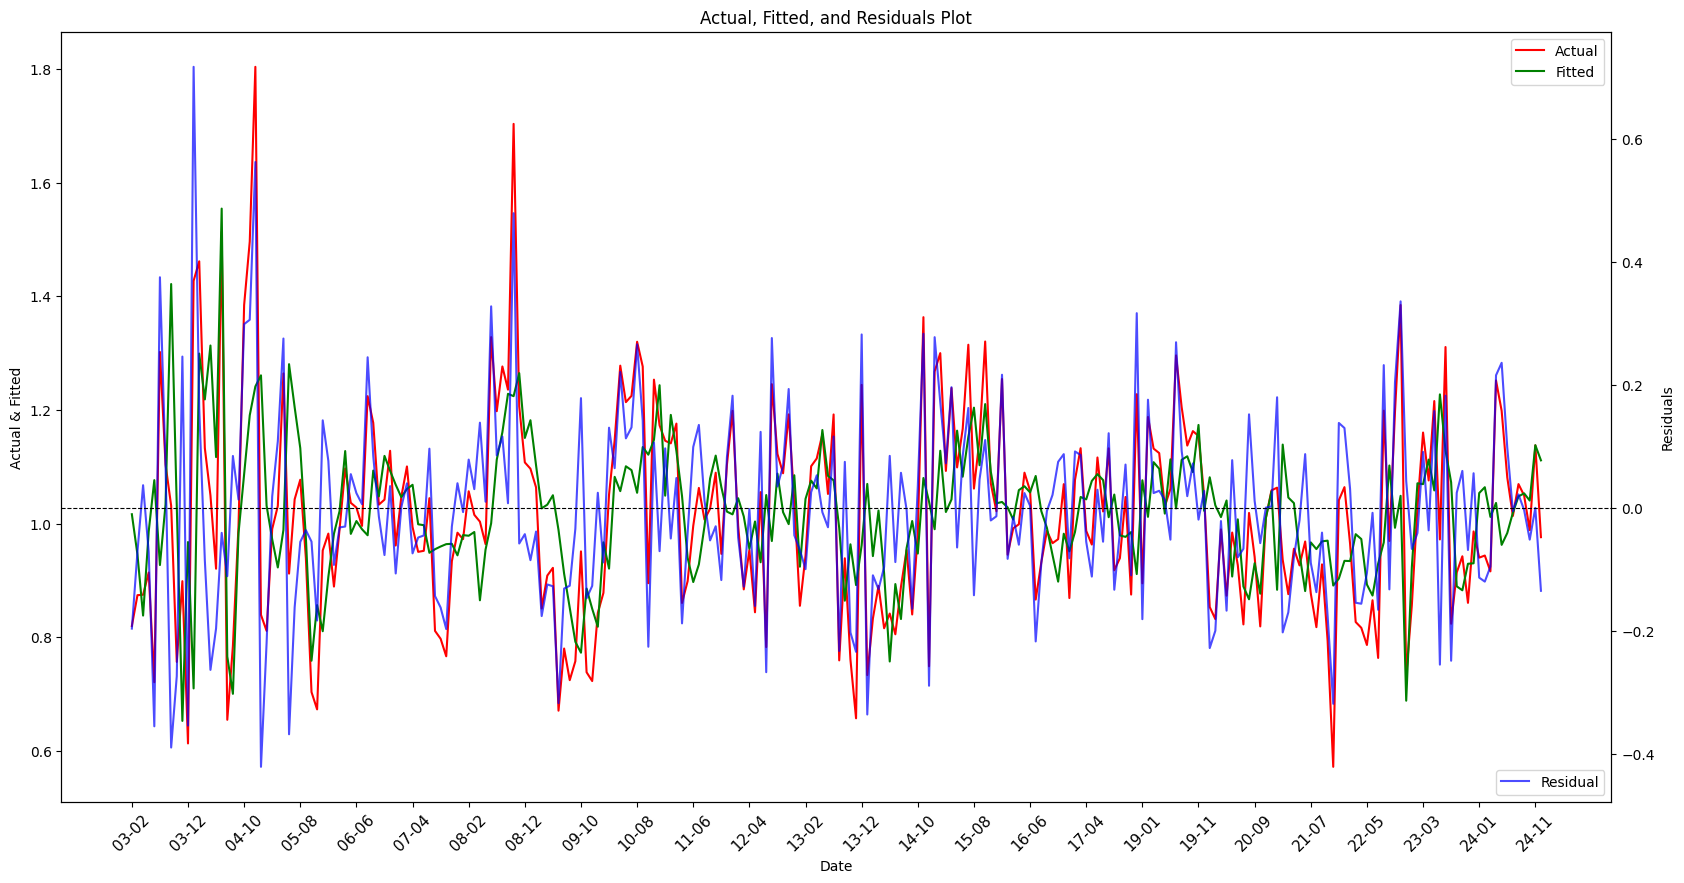

6 0 3
                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(6, 0, 3)   Log Likelihood                  90.476
Date:                Tue, 25 Feb 2025   AIC                           -150.953
Time:                        09:47:41   BIC                            -98.373
Sample:                             0   HQIC                          -129.781
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7537      0.289      2.608      0.009       0.187       1.320
EXP_T         -0.4147      0.249     -1.665      0.096      -0.903       0.073
SER0406        0.1899      0.094      2.020   

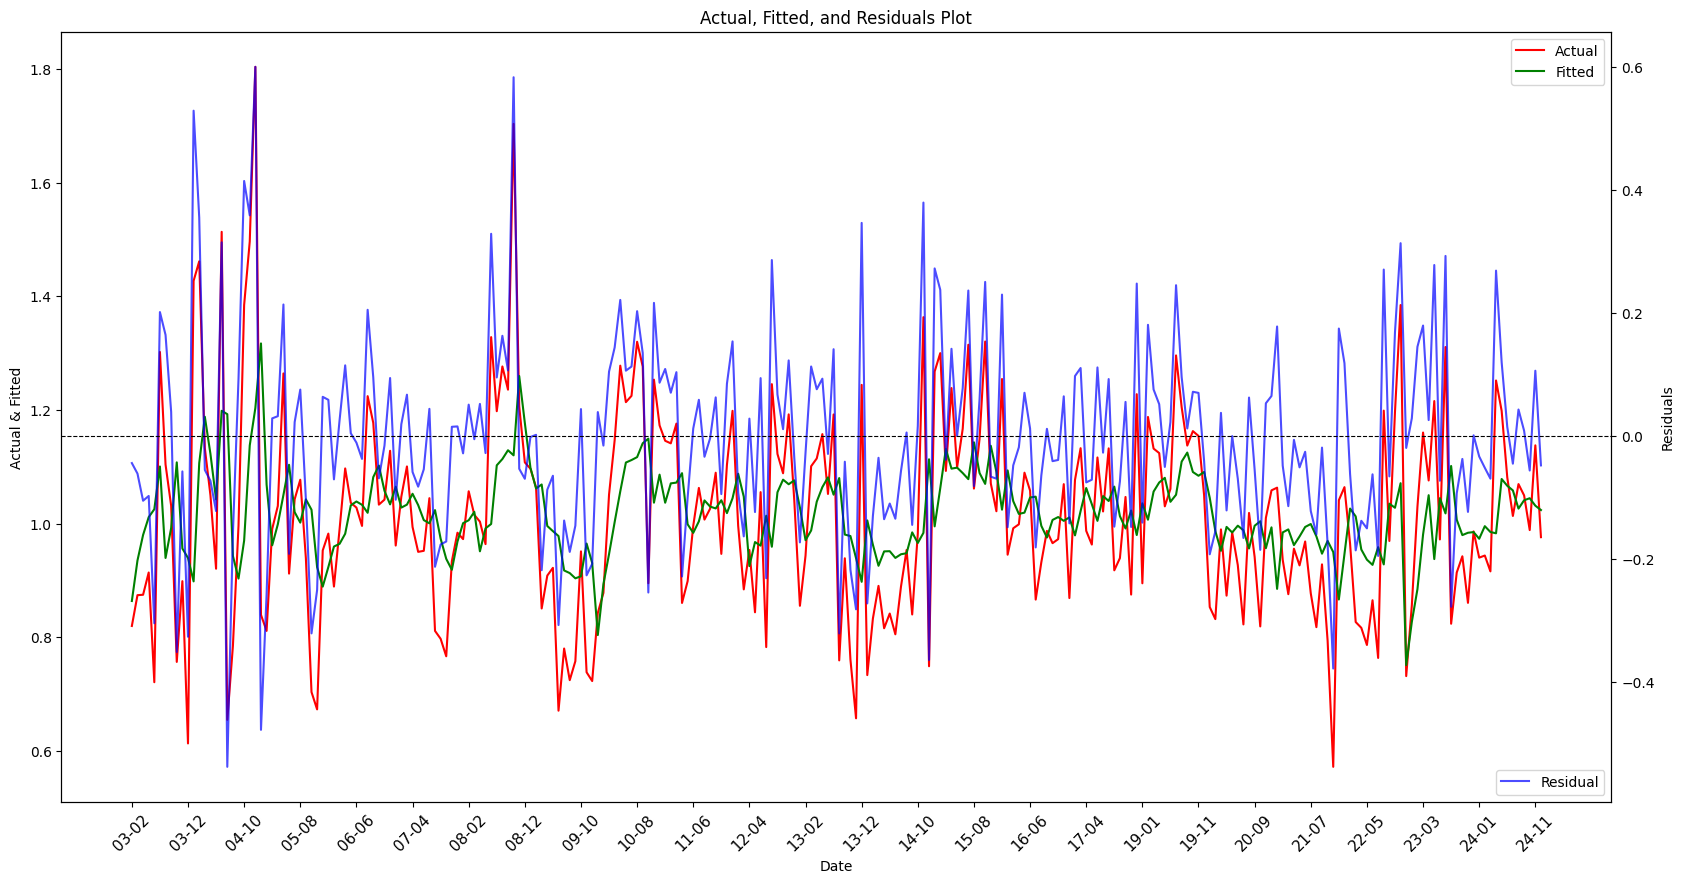

7 4 4
                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(7, 4, 4)   Log Likelihood                 -44.107
Date:                Tue, 25 Feb 2025   AIC                            122.213
Time:                        09:49:39   BIC                            181.455
Sample:                             0   HQIC                           146.081
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.974e-08   3.82e-05      0.001      1.000   -7.49e-05    7.49e-05
EXP_T         -0.6785      0.258     -2.629      0.009      -1.184      -0.173
SER0406        0.2237      0.149      1.500   

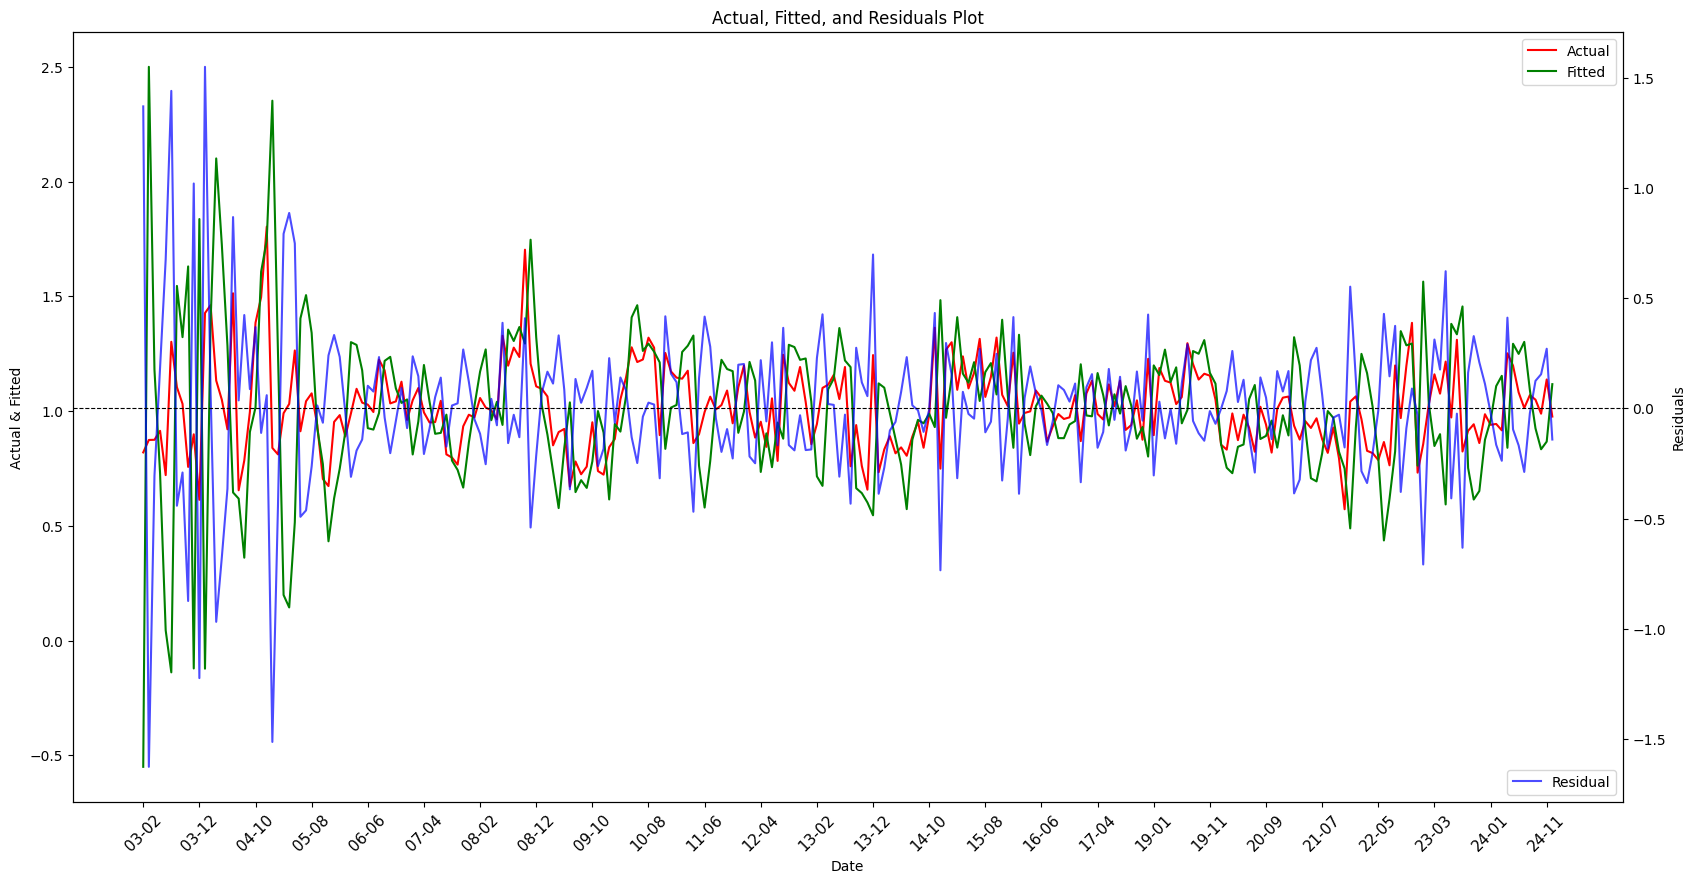

In [ ]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    #"M_SA": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную
X = sm.add_constant(X)
# Подбор оптимальных p, d, q
p_values = range(0, 10)
d_values = range(0, 5)
q_values = range(0, 10)

best_aic = float("inf")
best_order = None
best_model = None

for p, d, q in tqdm(itertools.product(p_values, d_values, q_values)):
    try:
        model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        # Достаем коэффициент и p-value для "T"
        coef_T = results.params.get("EXP_T", None)
        pval_T = results.pvalues.get("EXP_T", None)

        # Условие: коэффициент при T должен быть отрицательным и значимым (p < 0.05)
        if coef_T is not None and coef_T < 0 and pval_T is not None and pval_T < 0.1:
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results
            print(p, d, q)
            print(results.summary())
            plot_regression_results(results, df_type)

    except:
        continue

# Вывод результатов
if best_model:
    print(f"Лучшие параметры SARIMAX: {best_order}")
    print(best_model.summary())
    plot_regression_results(best_model, df_type)
else:
    print("Не удалось найти подходящую модель, удовлетворяющую условиям.")

In [53]:
commodity_type = 'nFerr'
type_dct = {
    "date": df_transportation_volumes.columns,
    "V_SA": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "EXP_T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "M_SA": df_volumes.loc[commodity_type],   # Production growth index
    #"P": df_world_prices.loc[commodity_type]   # World prices growth index
}

# Dummy-переменные
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
    type_dct[key] = value

df_type = pd.DataFrame(type_dct)

df_type["V_SA(-1)"] = df_type["V_SA"].shift(1)
df_type = df_type.dropna()
df_type.set_index('date', inplace=True)

# Целевая переменная и регрессоры
Y = df_type["V_SA"]
X = df_type.drop(columns=["V_SA"])  # Убираем целевую переменную
#X = sm.add_constant(X)

p, d, q = 5, 0, 3
model = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                          enforce_stationarity=False, enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())
plot_regression_results(model, df_type)

                               SARIMAX Results                                
Dep. Variable:                   V_SA   No. Observations:                  252
Model:               SARIMAX(5, 0, 3)   Log Likelihood                  91.897
Date:                Tue, 25 Feb 2025   AIC                           -155.795
Time:                        09:52:42   BIC                           -106.663
Sample:                             0   HQIC                          -136.014
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXP_T          0.4870      0.174      2.800      0.005       0.146       0.828
M_SA           0.2471      0.129      1.923      0.055      -0.005       0.499
SER0406        0.7675      0.172      4.450      0.0

AttributeError: 'SARIMAX' object has no attribute 'fittedvalues'

## 🐆 Plot Results

In [59]:
dct_model_params = {"уголь": [0, -0.16, 16], "железная руда": [0.04, -0.57, 16], "нефтепродукты": [0.5, -0.45, 16], "химикаты и сода": [0.04, -0.65, 16], 'зерно': [0.0489, -0.05, 16], 'цветные металлы': [0.34, -0.16, 16]}

In [60]:
def calc_elasticity(a, b, T):
    # T - tariff increase
    # a, b - model coefficients
    if a != 0:
        res = b * T / 100 / (a + b * T / 100) * 100
    else:
       res = b * T
    if res < -100 or res > 0:
        return -100
    else:
        return res

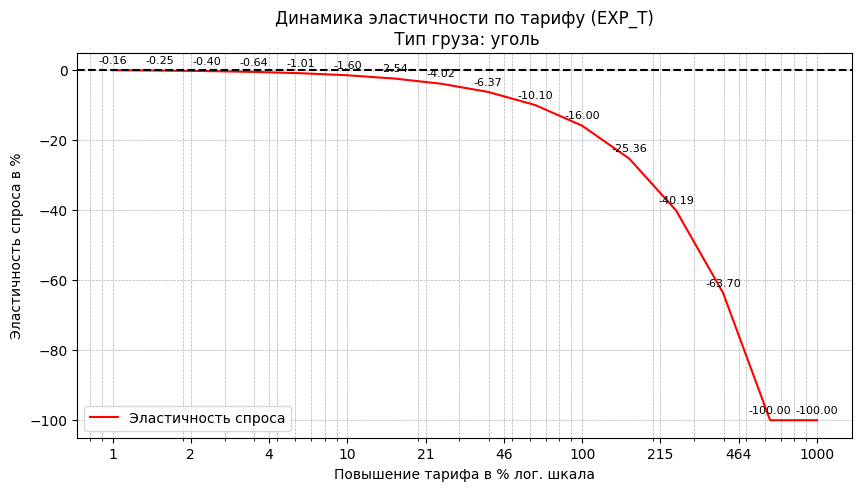

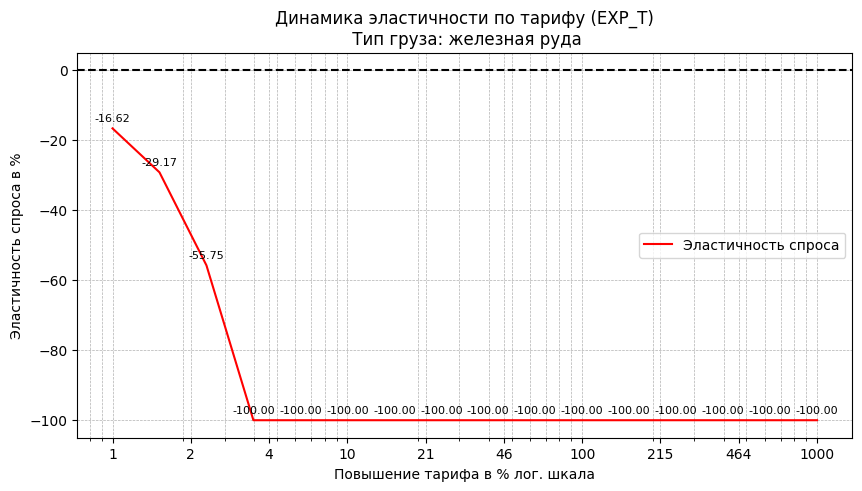

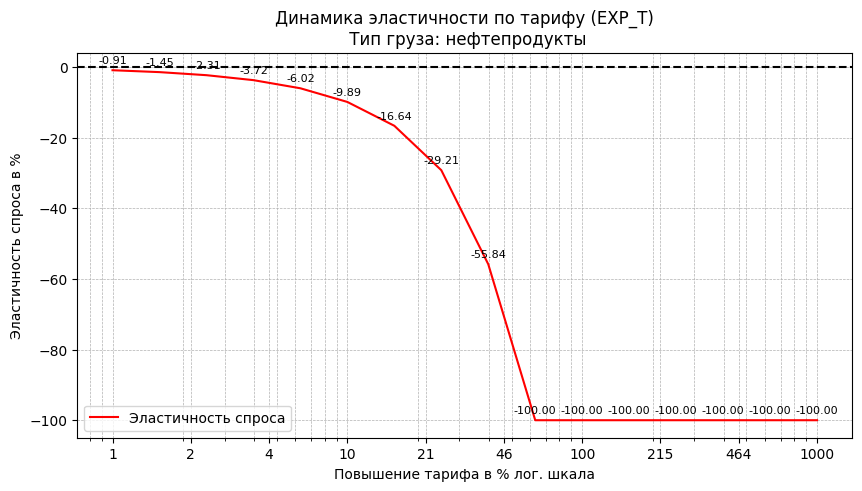

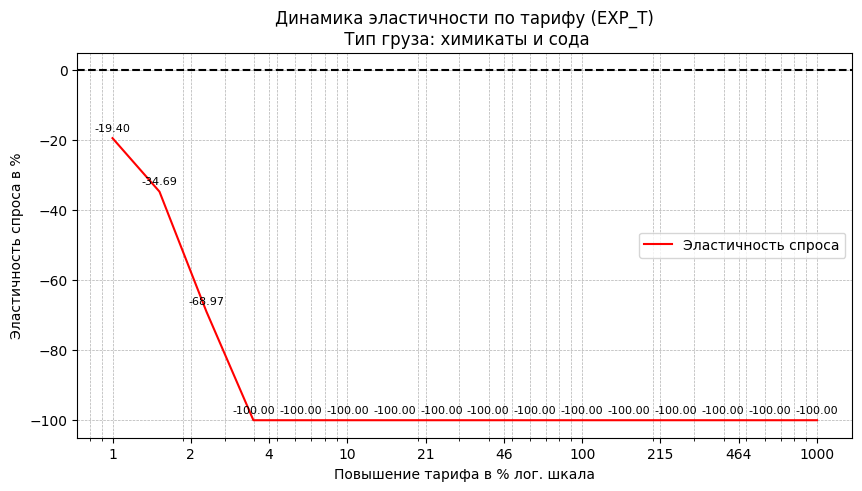

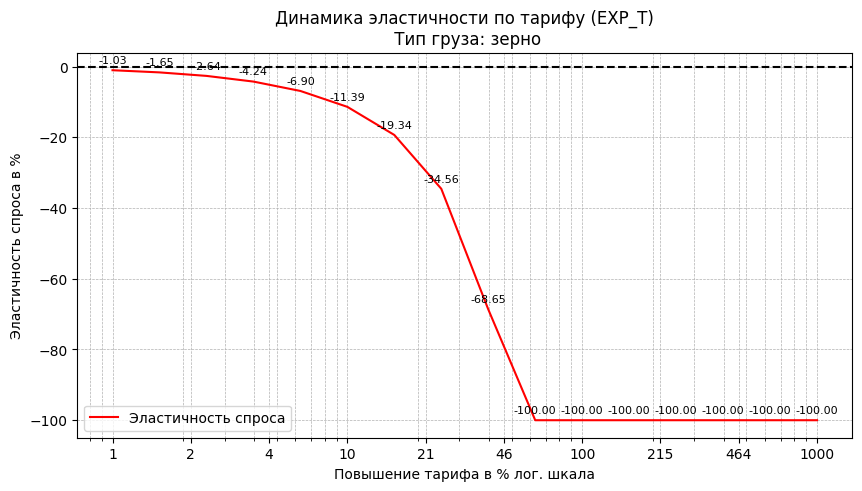

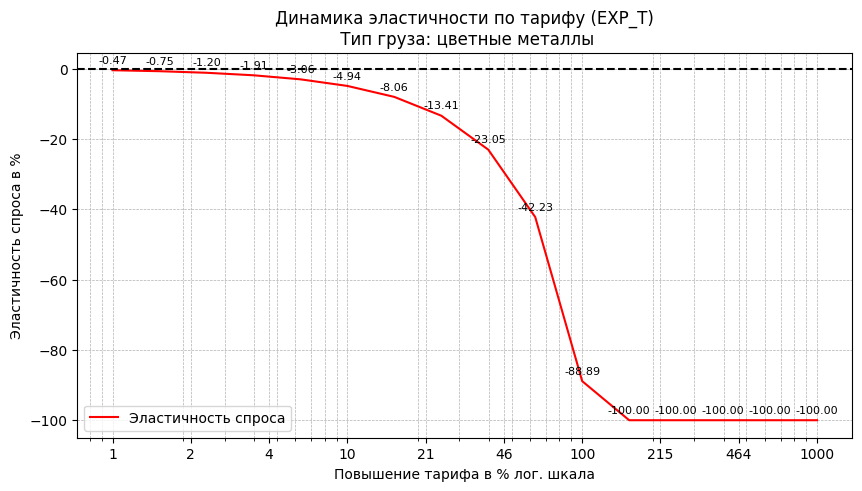

In [61]:
max_val = 1000  # Максимальное значение тарифа

for key, val in dct_model_params.items():
    T_values = np.logspace(0, np.log10(max_val), val[2])  # Генерируем больше значений T
    values = [calc_elasticity(val[0], val[1], T) for T in T_values]

    plt.figure(figsize=(10, 5))
    plt.plot(T_values, values, color='red', label="Эластичность спроса")
    plt.axhline(y=0, color='black', linestyle='--')

    # Подписываем **все точки** на кривой
    for i in range(len(values)):
        plt.annotate(f"{values[i]:.2f}", (T_values[i], values[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    plt.xlabel("Повышение тарифа в % лог. шкала")
    plt.ylabel("Эластичность спроса в %")
    plt.title(f"Динамика эластичности по тарифу (EXP_T)\n Тип груза: {key}")
    plt.xscale('log')  # Логарифмическая шкала для лучшей визуализации
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Добавляем сетку

    # ✅ Добавляем **больше подписей** по оси X
    tick_positions = np.logspace(0, np.log10(max_val), 10)  # 10 равномерных точек
    plt.xticks(tick_positions, [f"{int(x)}" for x in tick_positions])

    plt.show()
